<a href="https://colab.research.google.com/github/48harry/Smart-Shipping-Logistics-Abnormal-Operation-Diagnosis-Based-on-Abnormal-Signal-Detection/blob/main/%ED%95%B4%EC%96%91%EB%AC%BC%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA


Shape: (21693, 54)

타겟 클래스 분포:
target
0     0.047619
20    0.047619
1     0.047619
19    0.047619
15    0.047619
8     0.047619
16    0.047619
12    0.047619
14    0.047619
18    0.047619
3     0.047619
4     0.047619
5     0.047619
11    0.047619
13    0.047619
6     0.047619
10    0.047619
2     0.047619
9     0.047619
17    0.047619
7     0.047619
Name: proportion, dtype: float64

결측치 개수:
0

Feature Describe:
        count      mean       std    min       25%       50%       75%    max
X_01  21693.0  0.017989  0.004794 -0.003  0.015000  0.018000  0.021000  0.037
X_02  21693.0  0.258061  0.064098  0.000  0.244223  0.247364  0.251002  1.000
X_03  21693.0  0.533411  0.057962  0.000  0.510506  0.535398  0.560651  1.000
X_04  21693.0  0.510776  0.082500  0.000  0.507370  0.520045  0.533285  1.000
X_05  21693.0  0.421508  0.168995  0.000  0.363789  0.378157  0.393900  1.000


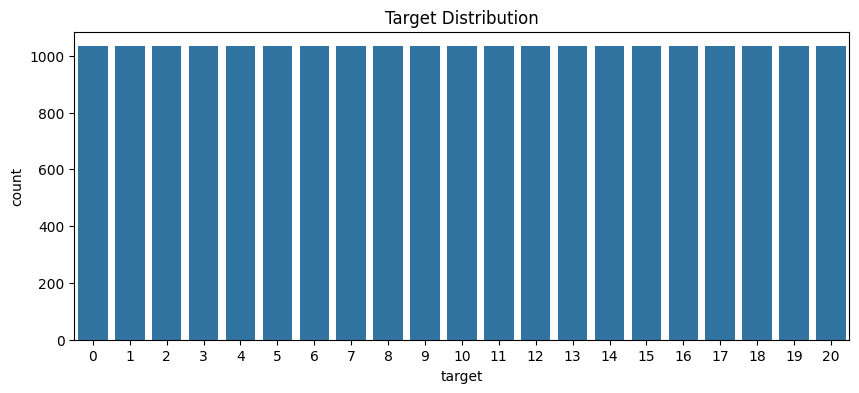

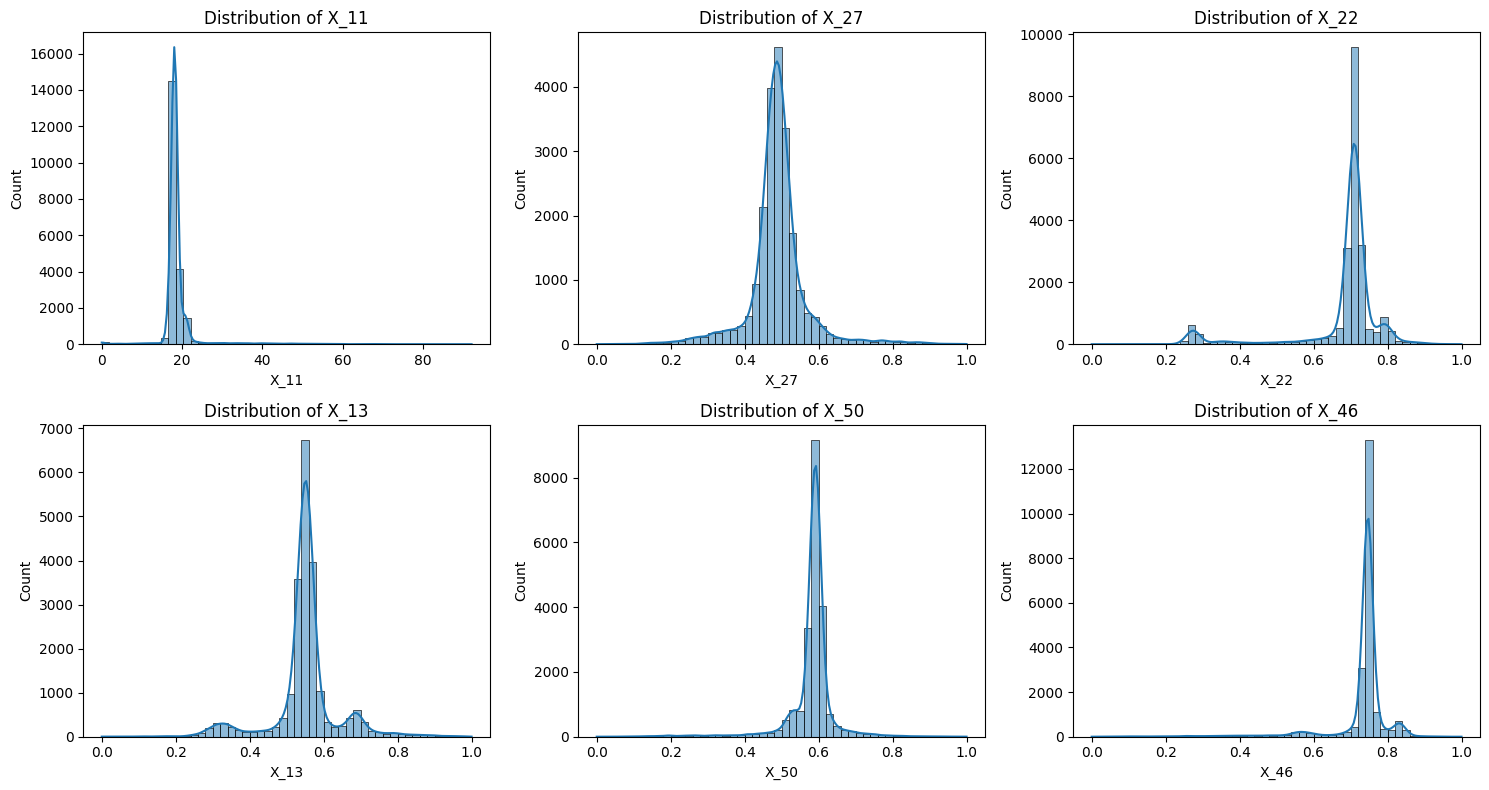

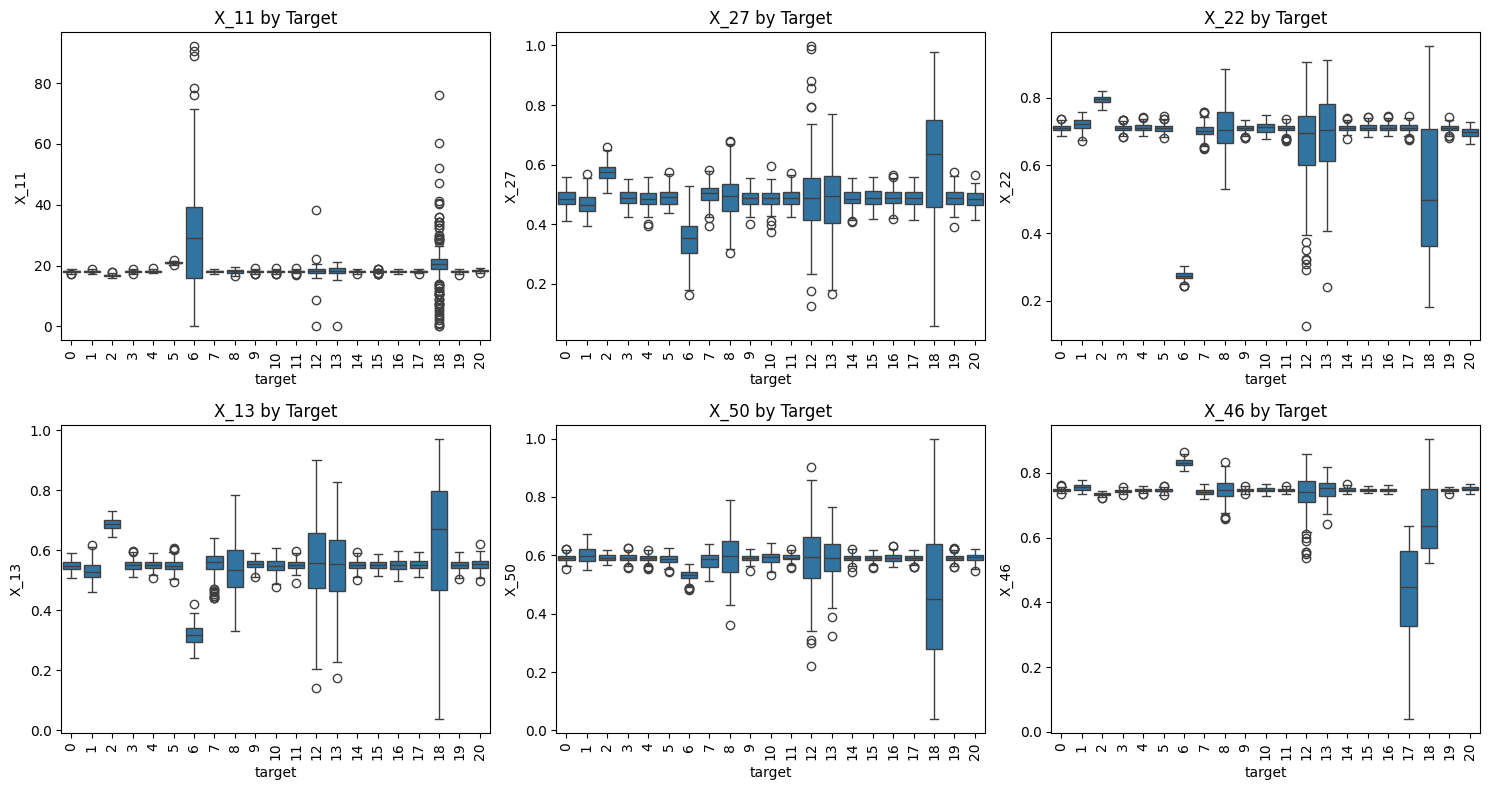

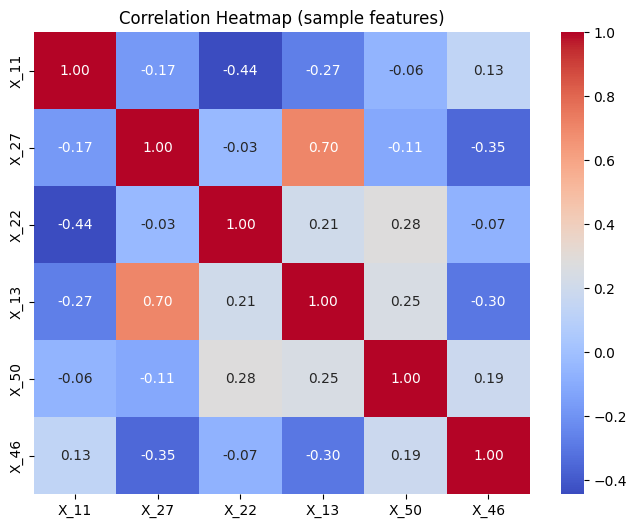


상위 10개 타겟 분별력 Feature:
   feature       f_score  p_value
6     X_07  14103.815059      0.0
32    X_33  13619.318977      0.0
17    X_18  11228.037704      0.0
27    X_28   9339.184391      0.0
37    X_38   8958.684142      0.0
46    X_47   7755.201135      0.0
25    X_26   6512.391953      0.0
15    X_16   6352.028027      0.0
29    X_30   6242.892004      0.0
50    X_51   4624.797378      0.0


In [ ]:
# =========================
# EDA 코드 (train.csv)
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 데이터 로드
train = pd.read_csv("/content/drive/MyDrive/dacon_sea/train.csv")

# -----------------------------
# 기본 정보 출력
print("Shape:", train.shape)
print("\n타겟 클래스 분포:")
print(train['target'].value_counts(normalize=True))

print("\n결측치 개수:")
print(train.isnull().sum().sum())

# -----------------------------
# 숫자형 피처 요약
feature_cols = [c for c in train.columns if c.startswith("X_")]
desc = train[feature_cols].describe().T
print("\nFeature Describe:")
print(desc.head())

# -----------------------------
# 타겟 분포 시각화
plt.figure(figsize=(10,4))
sns.countplot(x="target", data=train, order=sorted(train['target'].unique()))
plt.title("Target Distribution")
plt.show()

# -----------------------------
# 각 Feature의 분포 (랜덤 샘플 6개 피처만 표시)
sample_features = np.random.choice(feature_cols, size=6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15,8))
for ax, feat in zip(axes.ravel(), sample_features):
    sns.histplot(train[feat], bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {feat}")
plt.tight_layout()
plt.show()

# -----------------------------
# 타겟별 평균값 패턴 (랜덤 샘플 6개 피처)
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for ax, feat in zip(axes.ravel(), sample_features):
    sns.boxplot(x="target", y=feat, data=train.sample(5000), ax=ax)  # 속도 위해 5000개 샘플링
    ax.set_title(f"{feat} by Target")
    ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

# -----------------------------
# 상관관계 heatmap (샘플 피처만)
corr = train[sample_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (sample features)")
plt.show()

# -----------------------------
# 타겟과 피처 상관 (분산분석 기반 F-test 간단히 확인)
from sklearn.feature_selection import f_classif
X = train[feature_cols]
y = train['target']
f_vals, p_vals = f_classif(X, y)

feat_importance = pd.DataFrame({
    "feature": feature_cols,
    "f_score": f_vals,
    "p_value": p_vals
}).sort_values("f_score", ascending=False)

print("\n상위 10개 타겟 분별력 Feature:")
print(feat_importance.head(10))



# New Section


In [ ]:
!pip install catboost

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (21693, 54)
Test shape: (15004, 53)


In [ ]:
# Feature/Target 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()


# 1

In [ ]:

print(f"Feature 개수: {len(feature_cols)}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Random Forest 모델 설정
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))

Train shape: (21693, 54)
Test shape: (15004, 53)

=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Feature 개수: 52

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7311
Fold 2 Macro-F1: 0.7293
Fold 3 Macro-F1: 0.7241
Fold 4 Macro-F1: 0.7414
Fold 5 Macro-F1: 0.7285

평균 CV Macro-F1: 0.7309 (+/- 0.0115)

최종 모델 학습 중...

상위 10개 중요 피처:
   feature  importance
39    X_40    0.077597
10    X_11    0.076058
35    X_36    0.074255
45    X_46    0.070543
27    X_28    0.049448
41    X_42    0.046943
40    X_41    0.044051
6     X_07    0.037508
36    X_37    0.035190
32    X_33    0.032795


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/dacon_sea/train.csv'

# 2


In [ ]:
TRIAL_NUM = 2

# 기본 데이터 탐색
print("\n=== 기본 데이터 정보 ===")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치: {train.isnull().sum().sum()}")

# 피처와 타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Feature 개수: {len(feature_cols)}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Random Forest 모델 설정
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))

print("주요 변경사항:")
print("- n_estimators: 200 -> 300")
print("- max_depth: 15 -> 20")
print("- min_samples_split: 10 -> 5")
print("- min_samples_leaf: 5 -> 2")
print("- max_features: 'sqrt' 추가")


=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Feature 개수: 52

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7311
Fold 2 Macro-F1: 0.7293
Fold 3 Macro-F1: 0.7241
Fold 4 Macro-F1: 0.7414
Fold 5 Macro-F1: 0.7285

평균 CV Macro-F1: 0.7309 (+/- 0.0115)

최종 모델 학습 중...

상위 10개 중요 피처:
   feature  importance
39    X_40    0.077597
10    X_11    0.076058
35    X_36    0.074255
45    X_46    0.070543
27    X_28    0.049448
41    X_42    0.046943
40    X_41    0.044051
6     X_07    0.037508
36    X_37    0.035190
32    X_33    0.032795
주요 변경사항:
- n_estimators: 200 -> 300
- max_depth: 15 -> 20
- min_samples_split: 10 -> 5
- min_samples_leaf: 5 -> 2
- max_features: 'sqrt' 추가


# 3

In [ ]:
TRIAL_NUM = 3

# 피처 엔지니어링 (Trial 3: 중요 피처 기반 파생 변수 생성)
print("\n피처 엔지니어링 중...")

# 상위 중요 피처들 (이전 결과 기반)
top_features = ['X_40', 'X_11', 'X_36', 'X_46', 'X_28', 'X_42', 'X_41', 'X_07']

# 원본 피처로 시작
X_engineered = X.copy()
X_test_engineered = X_test.copy()

# 1. 중요 피처들 간의 비율 생성
ratio_count = 0
for i, feat1 in enumerate(top_features[:4]):  # 상위 4개 피처
    for feat2 in top_features[i+1:5]:  # 다음 피처들과 비교
        # 비율 피처 (0으로 나누기 방지)
        ratio_name = f"{feat1}_{feat2}_ratio"
        X_engineered[ratio_name] = X[feat1] / (X[feat2] + 1e-8)
        X_test_engineered[ratio_name] = X_test[feat1] / (X_test[feat2] + 1e-8)
        ratio_count += 1

print(f"생성된 비율 피처: {ratio_count}개")

# 2. 중요 피처들의 통계값
X_engineered['top4_mean'] = X[top_features[:4]].mean(axis=1)
X_engineered['top4_std'] = X[top_features[:4]].std(axis=1)
X_engineered['top4_max'] = X[top_features[:4]].max(axis=1)
X_engineered['top4_min'] = X[top_features[:4]].min(axis=1)

X_test_engineered['top4_mean'] = X_test[top_features[:4]].mean(axis=1)
X_test_engineered['top4_std'] = X_test[top_features[:4]].std(axis=1)
X_test_engineered['top4_max'] = X_test[top_features[:4]].max(axis=1)
X_test_engineered['top4_min'] = X_test[top_features[:4]].min(axis=1)

# 3. 전체 피처들의 통계값
X_engineered['all_mean'] = X.mean(axis=1)
X_engineered['all_std'] = X.std(axis=1)
X_engineered['all_range'] = X.max(axis=1) - X.min(axis=1)

X_test_engineered['all_mean'] = X_test.mean(axis=1)
X_test_engineered['all_std'] = X_test.std(axis=1)
X_test_engineered['all_range'] = X_test.max(axis=1) - X_test.min(axis=1)

print(f"엔지니어링 후 피처 개수: {X_engineered.shape[1]}")

# 새로 생성된 피처들의 샘플 확인
print("\n새 피처 샘플:")
new_features = [col for col in X_engineered.columns if col not in feature_cols]
print(f"새 피처명: {new_features[:5]}...")
print(f"첫 번째 샘플의 새 피처값: {X_engineered[new_features].iloc[0].values[:5]}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_test_scaled = scaler.transform(X_test_engineered)

# Random Forest 모델 설정 (Trial 3: 다른 랜덤시드 사용)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))


피처 엔지니어링 중...
생성된 비율 피처: 10개
엔지니어링 후 피처 개수: 69

새 피처 샘플:
새 피처명: ['X_40_X_11_ratio', 'X_40_X_36_ratio', 'X_40_X_46_ratio', 'X_40_X_28_ratio', 'X_11_X_36_ratio']...
첫 번째 샘플의 새 피처값: [  2.25578194  67.37976327  54.49543724 161.04368099  29.86980351]

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7236
Fold 2 Macro-F1: 0.7173
Fold 3 Macro-F1: 0.7242
Fold 4 Macro-F1: 0.7303
Fold 5 Macro-F1: 0.7230

평균 CV Macro-F1: 0.7237 (+/- 0.0083)

최종 모델 학습 중...

=== 예측 결과 디버깅 ===
Test predictions shape: (15004,)
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
First 10 predictions: [ 4  5 15 15 15  1  2 12  4  5]
예측 체크섬: 145123.671688

상위 10개 중요 피처:
            feature  importance
65         top4_min    0.044903
53  X_40_X_36_ratio    0.040872
57  X_11_X_46_ratio    0.038448
40             X_41    0.034418
39             X_40    0.032311
36             X_37    0.030141
63         top4_std    0.030101
41             X_42    0.030033
64         top4_max    0.030003
27  

# 4

In [ ]:
TRIAL_NUM = 4

# 상위 중요 피처들 (이전 결과 기반)
top_features = ['X_40', 'X_11', 'X_36', 'X_46', 'X_28', 'X_42', 'X_41', 'X_07']

# 원본 피처로 시작
X_engineered = X.copy()
X_test_engineered = X_test.copy()

# 1. 중요 피처들 간의 비율 생성
ratio_count = 0
for i, feat1 in enumerate(top_features[:4]):  # 상위 4개 피처
    for feat2 in top_features[i+1:5]:  # 다음 피처들과 비교
        # 비율 피처 (0으로 나누기 방지)
        ratio_name = f"{feat1}_{feat2}_ratio"
        X_engineered[ratio_name] = X[feat1] / (X[feat2] + 1e-8)
        X_test_engineered[ratio_name] = X_test[feat1] / (X_test[feat2] + 1e-8)
        ratio_count += 1

print(f"생성된 비율 피처: {ratio_count}개")

# 2. 중요 피처들의 통계값
X_engineered['top4_mean'] = X[top_features[:4]].mean(axis=1)
X_engineered['top4_std'] = X[top_features[:4]].std(axis=1)
X_engineered['top4_max'] = X[top_features[:4]].max(axis=1)
X_engineered['top4_min'] = X[top_features[:4]].min(axis=1)

X_test_engineered['top4_mean'] = X_test[top_features[:4]].mean(axis=1)
X_test_engineered['top4_std'] = X_test[top_features[:4]].std(axis=1)
X_test_engineered['top4_max'] = X_test[top_features[:4]].max(axis=1)
X_test_engineered['top4_min'] = X_test[top_features[:4]].min(axis=1)

# 3. 전체 피처들의 통계값
X_engineered['all_mean'] = X.mean(axis=1)
X_engineered['all_std'] = X.std(axis=1)
X_engineered['all_range'] = X.max(axis=1) - X.min(axis=1)

X_test_engineered['all_mean'] = X_test.mean(axis=1)
X_test_engineered['all_std'] = X_test.std(axis=1)
X_test_engineered['all_range'] = X_test.max(axis=1) - X_test.min(axis=1)

print(f"엔지니어링 후 피처 개수: {X_engineered.shape[1]}")

# 새로 생성된 피처들의 샘플 확인
print("\n새 피처 샘플:")
new_features = [col for col in X_engineered.columns if col not in feature_cols]
print(f"새 피처명: {new_features[:5]}...")
print(f"첫 번째 샘플의 새 피처값: {X_engineered[new_features].iloc[0].values[:5]}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_test_scaled = scaler.transform(X_test_engineered)

# Random Forest 모델 설정 (Trial 3: 다른 랜덤시드 사용)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,  # 42에서 123으로 변경
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)  # 시드 변경
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))

생성된 비율 피처: 10개
엔지니어링 후 피처 개수: 69

새 피처 샘플:
새 피처명: ['X_40_X_11_ratio', 'X_40_X_36_ratio', 'X_40_X_46_ratio', 'X_40_X_28_ratio', 'X_11_X_36_ratio']...
첫 번째 샘플의 새 피처값: [  2.25578194  67.37976327  54.49543724 161.04368099  29.86980351]

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7194
Fold 2 Macro-F1: 0.7248
Fold 3 Macro-F1: 0.7220
Fold 4 Macro-F1: 0.7253
Fold 5 Macro-F1: 0.7267

평균 CV Macro-F1: 0.7236 (+/- 0.0052)

최종 모델 학습 중...

=== 예측 결과 디버깅 ===
Test predictions shape: (15004,)
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
First 10 predictions: [ 4  5  0  0 15  1  2 12  4  5]
예측 체크섬: 125577.369035

상위 10개 중요 피처:
            feature  importance
39             X_40    0.036698
65         top4_min    0.036057
53  X_40_X_36_ratio    0.035806
63         top4_std    0.034129
57  X_11_X_46_ratio    0.032324
64         top4_max    0.032079
40             X_41    0.030210
36             X_37    0.029452
45             X_46    0.028637
32             X_33

# 5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Trial 번호 설정
TRIAL_NUM = 5

# 데이터 로드
print(f"=== Trial {TRIAL_NUM} 시작 ===")
print("데이터 로딩 중...")
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 기본 데이터 탐색
print("\n=== 기본 데이터 정보 ===")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치: {train.isnull().sum().sum()}")

# 피처와 타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Original Feature 개수: {len(feature_cols)}")

# 피처 엔지니어링 (Trial 3: 중요 피처 기반 파생 변수 생성)
print("\n피처 엔지니어링 중...")

# 상위 중요 피처들 (이전 결과 기반)
top_features = ['X_40', 'X_11', 'X_36', 'X_46', 'X_28', 'X_42', 'X_41', 'X_07']

# 원본 피처로 시작
X_engineered = X.copy()
X_test_engineered = X_test.copy()

# 1. 중요 피처들 간의 비율 생성
ratio_count = 0
for i, feat1 in enumerate(top_features[:4]):  # 상위 4개 피처
    for feat2 in top_features[i+1:5]:  # 다음 피처들과 비교
        # 비율 피처 (0으로 나누기 방지)
        ratio_name = f"{feat1}_{feat2}_ratio"
        X_engineered[ratio_name] = X[feat1] / (X[feat2] + 1e-8)
        X_test_engineered[ratio_name] = X_test[feat1] / (X_test[feat2] + 1e-8)
        ratio_count += 1

print(f"생성된 비율 피처: {ratio_count}개")

# 2. 중요 피처들의 통계값
X_engineered['top4_mean'] = X[top_features[:4]].mean(axis=1)
X_engineered['top4_std'] = X[top_features[:4]].std(axis=1)
X_engineered['top4_max'] = X[top_features[:4]].max(axis=1)
X_engineered['top4_min'] = X[top_features[:4]].min(axis=1)

X_test_engineered['top4_mean'] = X_test[top_features[:4]].mean(axis=1)
X_test_engineered['top4_std'] = X_test[top_features[:4]].std(axis=1)
X_test_engineered['top4_max'] = X_test[top_features[:4]].max(axis=1)
X_test_engineered['top4_min'] = X_test[top_features[:4]].min(axis=1)

# 3. 전체 피처들의 통계값
X_engineered['all_mean'] = X.mean(axis=1)
X_engineered['all_std'] = X.std(axis=1)
X_engineered['all_range'] = X.max(axis=1) - X.min(axis=1)

X_test_engineered['all_mean'] = X_test.mean(axis=1)
X_test_engineered['all_std'] = X_test.std(axis=1)
X_test_engineered['all_range'] = X_test.max(axis=1) - X_test.min(axis=1)

print(f"엔지니어링 후 피처 개수: {X_engineered.shape[1]}")

# 새로 생성된 피처들의 샘플 확인
print("\n새 피처 샘플:")
new_features = [col for col in X_engineered.columns if col not in feature_cols]
print(f"새 피처명: {new_features[:5]}...")
print(f"첫 번째 샘플의 새 피처값: {X_engineered[new_features].iloc[0].values[:5]}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_test_scaled = scaler.transform(X_test_engineered)

# Random Forest 모델 설정 (Trial 3: 다른 랜덤시드 사용)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,  # 42에서 123으로 변경
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)  # 시드 변경
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))

# 제출 파일 생성
submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")
print("주요 변경사항:")
print("- 앙상블 모델: Random Forest + XGBoost + LightGBM")
print("- 하드 보팅 방식으로 다수결 예측")
print("- 동일한 피처 엔지니어링 적용")
print(f"- 총 피처 개수: {X_engineered.shape[1]}개")

=== Trial 5 시작 ===
데이터 로딩 중...
Train shape: (21693, 54)
Test shape: (15004, 53)

=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Original Feature 개수: 52

피처 엔지니어링 중...
생성된 비율 피처: 10개
엔지니어링 후 피처 개수: 69

새 피처 샘플:
새 피처명: ['X_40_X_11_ratio', 'X_40_X_36_ratio', 'X_40_X_46_ratio', 'X_40_X_28_ratio', 'X_11_X_36_ratio']...
첫 번째 샘플의 새 피처값: [  2.25578194  67.37976327  54.49543724 161.04368099  29.86980351]

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7194
Fold 2 Macro-F1: 0.7248
Fold 3 Macro-F1: 0.7220
Fold 4 Macro-F1: 0.7253
Fold 5 Macro-F1: 0.7267

평균 CV Macro-F1: 0.7236 (+/- 0.0052)

최종 모델 학습 중...

=== 예측 결과 디버깅 ===
Test predictions shape: (15004,)
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
First 10 p

# 6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Trial 번호 설정
TRIAL_NUM = 6

# 데이터 로드
print(f"=== Trial {TRIAL_NUM} 시작 ===")
print("데이터 로딩 중...")
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 기본 데이터 탐색
print("\n=== 기본 데이터 정보 ===")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치: {train.isnull().sum().sum()}")

# 피처와 타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Original Feature 개수: {len(feature_cols)}")

# 피처 엔지니어링 (Trial 3: 중요 피처 기반 파생 변수 생성)
print("\n피처 엔지니어링 중...")

# 상위 중요 피처들 (이전 결과 기반)
top_features = ['X_40', 'X_11', 'X_36', 'X_46', 'X_28', 'X_42', 'X_41', 'X_07']

# 원본 피처로 시작
X_engineered = X.copy()
X_test_engineered = X_test.copy()

# 1. 중요 피처들 간의 비율 생성
ratio_count = 0
for i, feat1 in enumerate(top_features[:4]):  # 상위 4개 피처
    for feat2 in top_features[i+1:5]:  # 다음 피처들과 비교
        # 비율 피처 (0으로 나누기 방지)
        ratio_name = f"{feat1}_{feat2}_ratio"
        X_engineered[ratio_name] = X[feat1] / (X[feat2] + 1e-8)
        X_test_engineered[ratio_name] = X_test[feat1] / (X_test[feat2] + 1e-8)
        ratio_count += 1

print(f"생성된 비율 피처: {ratio_count}개")

# 2. 중요 피처들의 통계값
X_engineered['top4_mean'] = X[top_features[:4]].mean(axis=1)
X_engineered['top4_std'] = X[top_features[:4]].std(axis=1)
X_engineered['top4_max'] = X[top_features[:4]].max(axis=1)
X_engineered['top4_min'] = X[top_features[:4]].min(axis=1)

X_test_engineered['top4_mean'] = X_test[top_features[:4]].mean(axis=1)
X_test_engineered['top4_std'] = X_test[top_features[:4]].std(axis=1)
X_test_engineered['top4_max'] = X_test[top_features[:4]].max(axis=1)
X_test_engineered['top4_min'] = X_test[top_features[:4]].min(axis=1)

# 3. 전체 피처들의 통계값
X_engineered['all_mean'] = X.mean(axis=1)
X_engineered['all_std'] = X.std(axis=1)
X_engineered['all_range'] = X.max(axis=1) - X.min(axis=1)

X_test_engineered['all_mean'] = X_test.mean(axis=1)
X_test_engineered['all_std'] = X_test.std(axis=1)
X_test_engineered['all_range'] = X_test.max(axis=1) - X_test.min(axis=1)

print(f"엔지니어링 후 피처 개수: {X_engineered.shape[1]}")

# 새로 생성된 피처들의 샘플 확인
print("\n새 피처 샘플:")
new_features = [col for col in X_engineered.columns if col not in feature_cols]
print(f"새 피처명: {new_features[:5]}...")
print(f"첫 번째 샘플의 새 피처값: {X_engineered[new_features].iloc[0].values[:5]}")

# 전처리 - 표준화
print("\n데이터 전처리 중...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_test_scaled = scaler.transform(X_test_engineered)

# Random Forest 모델 설정 (Trial 3: 다른 랜덤시드 사용)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=123,  # 42에서 123으로 변경
    n_jobs=-1
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)  # 시드 변경
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = rf_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 모델 학습 중...")
rf_model.fit(X_scaled, y)

# 테스트 예측
test_predictions = rf_model.predict(X_test_scaled)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 피처 중요도 확인
feature_importance = pd.DataFrame({
    'feature': X_engineered.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 피처:")
print(feature_importance.head(10))

# 제출 파일 생성
submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")
print("주요 변경사항:")
print("- 피처 엔지니어링 대폭 확장 (비율, 차이, 곱셈 피처)")
print("- 고급 통계 피처 (중앙값, 왜도, 첨도 등)")
print("- 비선형 변환 피처 (제곱, 제곱근, 로그)")
print("- XGBoost 하이퍼파라미터 강화 (n_est=300, depth=8, lr=0.05)")
print(f"- 총 피처 개수: {X_engineered.shape[1]}개")

=== Trial 6 시작 ===
데이터 로딩 중...
Train shape: (21693, 54)
Test shape: (15004, 53)

=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Original Feature 개수: 52

피처 엔지니어링 중...
생성된 비율 피처: 10개
엔지니어링 후 피처 개수: 69

새 피처 샘플:
새 피처명: ['X_40_X_11_ratio', 'X_40_X_36_ratio', 'X_40_X_46_ratio', 'X_40_X_28_ratio', 'X_11_X_36_ratio']...
첫 번째 샘플의 새 피처값: [  2.25578194  67.37976327  54.49543724 161.04368099  29.86980351]

데이터 전처리 중...

교차 검증 수행 중...
Fold 1 Macro-F1: 0.7194
Fold 2 Macro-F1: 0.7248
Fold 3 Macro-F1: 0.7220
Fold 4 Macro-F1: 0.7253
Fold 5 Macro-F1: 0.7267

평균 CV Macro-F1: 0.7236 (+/- 0.0052)

최종 모델 학습 중...

=== 예측 결과 디버깅 ===
Test predictions shape: (15004,)
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
First 10 p

# 7

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Trial 번호 설정
TRIAL_NUM = 7

# 데이터 로드
print(f"=== Trial {TRIAL_NUM} 시작 (런타임 재시작 후) ===")
print("데이터 로딩 중...")
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 기본 데이터 탐색
print("\n=== 기본 데이터 정보 ===")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치: {train.isnull().sum().sum()}")

# 피처와 타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Original Feature 개수: {len(feature_cols)}")

# 대폭 다른 피처 엔지니어링 (Trial 7: PCA + 클러스터링 + 비율)
print("\n=== 새로운 피처 엔지니어링 시작 ===")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. PCA 피처 생성 (차원 축소보다는 새로운 피처 생성 목적)
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

# PCA 피처를 데이터프레임에 추가
for i in range(10):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

print(f"PCA 피처 10개 추가 완료")

# 2. K-means 클러스터링 피처
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
X_cluster = kmeans.fit_predict(X[feature_cols])
X_test_cluster = kmeans.predict(X_test[feature_cols])

X['cluster'] = X_cluster
X_test['cluster'] = X_test_cluster

# 클러스터 중심까지의 거리
cluster_distances = []
test_cluster_distances = []

for i in range(len(X)):
    cluster_id = X_cluster[i]
    distance = np.linalg.norm(X.iloc[i][feature_cols].values - kmeans.cluster_centers_[cluster_id])
    cluster_distances.append(distance)

for i in range(len(X_test)):
    cluster_id = X_test_cluster[i]
    distance = np.linalg.norm(X_test.iloc[i][feature_cols].values - kmeans.cluster_centers_[cluster_id])
    test_cluster_distances.append(distance)

X['cluster_distance'] = cluster_distances
X_test['cluster_distance'] = test_cluster_distances

print(f"클러스터 피처 2개 추가 완료")

# 3. 통계 기반 피처들 (더 체계적으로)
# 분위수 기반 피처
X['q25'] = X[feature_cols].quantile(0.25, axis=1)
X['q75'] = X[feature_cols].quantile(0.75, axis=1)
X['iqr'] = X['q75'] - X['q25']

X_test['q25'] = X_test[feature_cols].quantile(0.25, axis=1)
X_test['q75'] = X_test[feature_cols].quantile(0.75, axis=1)
X_test['iqr'] = X_test['q75'] - X_test['q25']

# 상위/하위 피처들의 합
top_10_features = feature_cols[:10]  # 임의로 앞의 10개
bottom_10_features = feature_cols[-10:]  # 뒤의 10개

X['top10_sum'] = X[top_10_features].sum(axis=1)
X['bottom10_sum'] = X[bottom_10_features].sum(axis=1)
X['top_bottom_ratio'] = X['top10_sum'] / (X['bottom10_sum'] + 1e-8)

X_test['top10_sum'] = X_test[top_10_features].sum(axis=1)
X_test['bottom10_sum'] = X_test[bottom_10_features].sum(axis=1)
X_test['top_bottom_ratio'] = X_test['top10_sum'] / (X_test['bottom10_sum'] + 1e-8)

print(f"통계 피처 6개 추가 완료")

# 4. 원본 중요 피처들 기반 파생 피처 (이전 결과 기반)
important_features = ['X_40', 'X_11', 'X_36', 'X_46']

for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        X[f'{feat1}_div_{feat2}'] = X[feat1] / (X[feat2] + 1e-8)
        X_test[f'{feat1}_div_{feat2}'] = X_test[feat1] / (X_test[feat2] + 1e-8)

print(f"중요 피처 기반 비율 피처 추가 완료")

print(f"\n최종 피처 개수: {X.shape[1]}")
print(f"새로 추가된 피처들 확인:")
new_features = [col for col in X.columns if col not in feature_cols]
print(f"새 피처들: {new_features}")

# 전처리 - RobustScaler 사용 (이상치에 더 강함)
print("\n데이터 전처리 중 (RobustScaler 사용)...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 피처 선택 (상위 100개만 선택)
print("\n피처 선택 중...")
selector = SelectKBest(score_func=f_classif, k=min(100, X.shape[1]-1))
X_selected = selector.fit_transform(X_scaled, y)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"선택된 피처 개수: {len(selected_features)}")
print(f"선택된 주요 피처들: {selected_features[:10].tolist()}")

# XGBoost 모델 (다른 하이퍼파라미터)
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=777,  # 다른 시드
    n_jobs=-1,
    eval_metric='mlogloss'
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_selected, y)):
    X_train, X_val = X_selected[train_idx], X_selected[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    xgb_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = xgb_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 XGBoost 모델 학습 중...")
xgb_model.fit(X_selected, y)

# 테스트 예측
test_predictions = xgb_model.predict(X_test_selected)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 제출 파일 생성
submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")
print("주요 변경사항:")
print("- PCA 피처 10개 추가")
print("- K-means 클러스터 피처 2개 추가")
print("- 분위수 기반 통계 피처 6개 추가")
print("- RobustScaler 사용 (이상치에 강함)")
print("- SelectKBest로 상위 100개 피처 선택")
print("- 완전히 다른 XGBoost 하이퍼파라미터 (lr=0.03, reg=0.5)")
print("- 다른 랜덤 시드 (777)")
print(f"- 최종 선택된 피처 개수: {len(selected_features)}개")

=== Trial 7 시작 (런타임 재시작 후) ===
데이터 로딩 중...
Train shape: (21693, 54)
Test shape: (15004, 53)

=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Original Feature 개수: 52

=== 새로운 피처 엔지니어링 시작 ===
PCA 피처 10개 추가 완료
클러스터 피처 2개 추가 완료
통계 피처 6개 추가 완료
중요 피처 기반 비율 피처 추가 완료

최종 피처 개수: 76
새로 추가된 피처들 확인:
새 피처들: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'cluster', 'cluster_distance', 'q25', 'q75', 'iqr', 'top10_sum', 'bottom10_sum', 'top_bottom_ratio', 'X_40_div_X_11', 'X_40_div_X_36', 'X_40_div_X_46', 'X_11_div_X_36', 'X_11_div_X_46', 'X_36_div_X_46']

데이터 전처리 중 (RobustScaler 사용)...

피처 선택 중...
선택된 피처 개수: 75
선택된 주요 피처들: ['X_01', 'X_02', 'X_03', 'X_04', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09', 'X_10']

교차 검증

# 8

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier

# Trial 번호 설정
TRIAL_NUM = 8

# 데이터 로드
print(f"=== Trial {TRIAL_NUM} 시작 (런타임 재시작 후) ===")
print("데이터 로딩 중...")
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 기본 데이터 탐색
print("\n=== 기본 데이터 정보 ===")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치: {train.isnull().sum().sum()}")

# 피처와 타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Original Feature 개수: {len(feature_cols)}")

# 대폭 다른 피처 엔지니어링 (Trial 7: PCA + 클러스터링 + 비율)
print("\n=== 새로운 피처 엔지니어링 시작 ===")

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. PCA 피처 생성 (더 많은 컴포넌트)
pca = PCA(n_components=15, random_state=42)  # 10 -> 15
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

# PCA 피처를 데이터프레임에 추가
for i in range(15):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

print(f"PCA 피처 15개 추가 완료")

# 2. K-means 클러스터링 피처 (더 많은 클러스터)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)  # 8 -> 12
X_cluster = kmeans.fit_predict(X[feature_cols])
X_test_cluster = kmeans.predict(X_test[feature_cols])

X['cluster'] = X_cluster
X_test['cluster'] = X_test_cluster

# 클러스터 중심까지의 거리
cluster_distances = []
test_cluster_distances = []

for i in range(len(X)):
    cluster_id = X_cluster[i]
    distance = np.linalg.norm(X.iloc[i][feature_cols].values - kmeans.cluster_centers_[cluster_id])
    cluster_distances.append(distance)

for i in range(len(X_test)):
    cluster_id = X_test_cluster[i]
    distance = np.linalg.norm(X_test.iloc[i][feature_cols].values - kmeans.cluster_centers_[cluster_id])
    test_cluster_distances.append(distance)

X['cluster_distance'] = cluster_distances
X_test['cluster_distance'] = test_cluster_distances

print(f"클러스터 피처 2개 추가 완료")

# 3. 더 다양한 통계 기반 피처들
# 기존 분위수 기반 피처
X['q25'] = X[feature_cols].quantile(0.25, axis=1)
X['q75'] = X[feature_cols].quantile(0.75, axis=1)
X['iqr'] = X['q75'] - X['q25']

X_test['q25'] = X_test[feature_cols].quantile(0.25, axis=1)
X_test['q75'] = X_test[feature_cols].quantile(0.75, axis=1)
X_test['iqr'] = X_test['q75'] - X_test['q25']

# 추가 분위수
X['q10'] = X[feature_cols].quantile(0.1, axis=1)
X['q90'] = X[feature_cols].quantile(0.9, axis=1)
X['q10_90_range'] = X['q90'] - X['q10']

X_test['q10'] = X_test[feature_cols].quantile(0.1, axis=1)
X_test['q90'] = X_test[feature_cols].quantile(0.9, axis=1)
X_test['q10_90_range'] = X_test['q90'] - X_test['q10']

# 상위/하위 피처들의 합
top_15_features = feature_cols[:15]  # 10 -> 15
bottom_15_features = feature_cols[-15:]  # 10 -> 15

X['top15_sum'] = X[top_15_features].sum(axis=1)
X['bottom15_sum'] = X[bottom_15_features].sum(axis=1)
X['top_bottom_ratio'] = X['top15_sum'] / (X['bottom15_sum'] + 1e-8)

X_test['top15_sum'] = X_test[top_15_features].sum(axis=1)
X_test['bottom15_sum'] = X_test[bottom_15_features].sum(axis=1)
X_test['top_bottom_ratio'] = X_test['top15_sum'] / (X_test['bottom15_sum'] + 1e-8)

print(f"확장된 통계 피처 9개 추가 완료")

# 4. 원본 중요 피처들 기반 파생 피처 (이전 결과 기반)
important_features = ['X_40', 'X_11', 'X_36', 'X_46']

for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        X[f'{feat1}_div_{feat2}'] = X[feat1] / (X[feat2] + 1e-8)
        X_test[f'{feat1}_div_{feat2}'] = X_test[feat1] / (X_test[feat2] + 1e-8)

print(f"중요 피처 기반 비율 피처 추가 완료")

print(f"\n최종 피처 개수: {X.shape[1]}")
print(f"새로 추가된 피처들 확인:")
new_features = [col for col in X.columns if col not in feature_cols]
print(f"새 피처들: {new_features}")

# 전처리 - RobustScaler 사용 (이상치에 더 강함)
print("\n데이터 전처리 중 (RobustScaler 사용)...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# 피처 선택 (상위 120개로 확장)
print("\n피처 선택 중...")
selector = SelectKBest(score_func=f_classif, k=min(120, X.shape[1]-1))  # 100 -> 120
X_selected = selector.fit_transform(X_scaled, y)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"선택된 피처 개수: {len(selected_features)}")
print(f"선택된 주요 피처들: {selected_features[:10].tolist()}")

# XGBoost 모델 (세밀한 튜닝)
xgb_model = XGBClassifier(
    n_estimators=800,        # 500 -> 800
    max_depth=6,            # 7 -> 6 (과적합 방지)
    learning_rate=0.02,     # 0.03 -> 0.02 (더 보수적)
    subsample=0.8,          # 0.7 -> 0.8
    colsample_bytree=0.8,   # 0.7 -> 0.8
    reg_alpha=0.3,          # 0.5 -> 0.3
    reg_lambda=0.3,         # 0.5 -> 0.3
    random_state=777,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# 교차 검증으로 성능 평가
print("\n교차 검증 수행 중...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_selected, y)):
    X_train, X_val = X_selected[train_idx], X_selected[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 모델 학습
    xgb_model.fit(X_train, y_train)

    # 예측 및 평가
    y_pred = xgb_model.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(macro_f1)

    print(f"Fold {fold+1} Macro-F1: {macro_f1:.4f}")

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 전체 데이터로 최종 모델 학습
print("\n최종 XGBoost 모델 학습 중...")
xgb_model.fit(X_selected, y)

# 테스트 예측
test_predictions = xgb_model.predict(X_test_selected)

# 예측 결과 디버깅 정보
print(f"\n=== 예측 결과 디버깅 ===")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Unique predictions: {np.unique(test_predictions)}")
print(f"First 10 predictions: {test_predictions[:10]}")

# 이전 trial들과 비교용 체크섬
checksum = np.sum(test_predictions) + np.mean(test_predictions)
print(f"예측 체크섬: {checksum:.6f}")

# 제출 파일 생성
submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")
print("주요 변경사항:")
print("- PCA 피처 10개 -> 15개로 확장")
print("- K-means 클러스터 8개 -> 12개로 확장")
print("- 통계 피처 대폭 확장 (Q10, Q90, 더 많은 상위/하위 그룹)")
print("- 피처 선택 100개 -> 120개로 확장")
print("- XGBoost 세밀 튜닝 (n_est=800, lr=0.02, depth=6)")
print("- 정규화 완화 (0.5 -> 0.3)")
print(f"- 최종 선택된 피처 개수: {len(selected_features)}개")

=== Trial 8 시작 (런타임 재시작 후) ===
데이터 로딩 중...
Train shape: (21693, 54)
Test shape: (15004, 53)

=== 기본 데이터 정보 ===
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치: 0
Original Feature 개수: 52

=== 새로운 피처 엔지니어링 시작 ===
PCA 피처 15개 추가 완료
클러스터 피처 2개 추가 완료
확장된 통계 피처 9개 추가 완료
중요 피처 기반 비율 피처 추가 완료

최종 피처 개수: 84
새로 추가된 피처들 확인:
새 피처들: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'cluster', 'cluster_distance', 'q25', 'q75', 'iqr', 'q10', 'q90', 'q10_90_range', 'top15_sum', 'bottom15_sum', 'top_bottom_ratio', 'X_40_div_X_11', 'X_40_div_X_36', 'X_40_div_X_46', 'X_11_div_X_36', 'X_11_div_X_46', 'X_36_div_X_46']

데이터 전처리 중 (RobustScaler 사용)...

피처 선택 중...
선택된 피처 개수: 83
선택된 주요 피처들: ['X

#9


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Trial 번호 설정
TRIAL_NUM = 9

# 데이터 로드
print(f"=== Trial {TRIAL_NUM} 시작 (런타임 재시작 후) ===")
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Target 분포:\n{train['target'].value_counts().sort_index()}")
print(f"결측치 총합: {train.isnull().sum().sum()}")

# 피처/타겟 분리
feature_cols = [col for col in train.columns if col.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

print(f"Original Feature 개수: {len(feature_cols)}")

# ============================
# Feature Engineering
# ============================

# 1. PCA 피처 (15 components)
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

for i in range(15):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]
print("PCA 피처 15개 추가 완료")

# 2. KMeans 클러스터링 (12 clusters + distance)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
X_cluster = kmeans.fit_predict(X[feature_cols])
X_test_cluster = kmeans.predict(X_test[feature_cols])

X['cluster'] = X_cluster
X_test['cluster'] = X_test_cluster

cluster_distances = [
    np.linalg.norm(X.iloc[i][feature_cols].values - kmeans.cluster_centers_[cid])
    for i, cid in enumerate(X_cluster)
]
test_cluster_distances = [
    np.linalg.norm(X_test.iloc[i][feature_cols].values - kmeans.cluster_centers_[cid])
    for i, cid in enumerate(X_test_cluster)
]

X['cluster_distance'] = cluster_distances
X_test['cluster_distance'] = test_cluster_distances
print("클러스터 피처 2개 추가 완료")

# 3. 통계 기반 피처
for df, feats in [(X, feature_cols), (X_test, feature_cols)]:
    df['q25'] = df[feats].quantile(0.25, axis=1)
    df['q75'] = df[feats].quantile(0.75, axis=1)
    df['iqr'] = df['q75'] - df['q25']
    df['q10'] = df[feats].quantile(0.1, axis=1)
    df['q90'] = df[feats].quantile(0.9, axis=1)
    df['q10_90_range'] = df['q90'] - df['q10']

top_15_features = feature_cols[:15]
bottom_15_features = feature_cols[-15:]

X['top15_sum'] = X[top_15_features].sum(axis=1)
X['bottom15_sum'] = X[bottom_15_features].sum(axis=1)
X['top_bottom_ratio'] = X['top15_sum'] / (X['bottom15_sum'] + 1e-8)

X_test['top15_sum'] = X_test[top_15_features].sum(axis=1)
X_test['bottom15_sum'] = X_test[bottom_15_features].sum(axis=1)
X_test['top_bottom_ratio'] = X_test['top15_sum'] / (X_test['bottom15_sum'] + 1e-8)

print("통계 피처 9개 추가 완료")

# 4. 중요 피처 기반 ratio 피처
important_features = ['X_40', 'X_11', 'X_36', 'X_46']
for i, f1 in enumerate(important_features):
    for f2 in important_features[i+1:]:
        X[f'{f1}_div_{f2}'] = X[f1] / (X[f2] + 1e-8)
        X_test[f'{f1}_div_{f2}'] = X_test[f1] / (X_test[f2] + 1e-8)

print("중요 피처 ratio 추가 완료")

print(f"최종 피처 개수: {X.shape[1]}")

# ============================
# Preprocessing & Feature Selection
# ============================

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=min(120, X.shape[1]-1))
X_selected = selector.fit_transform(X_scaled, y)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]
print(f"선택된 피처 개수: {len(selected_features)}")
print(f"주요 피처: {selected_features[:10].tolist()}")

# ============================
# Model
# ============================

xgb_model = XGBClassifier(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.3,
    reg_lambda=0.3,
    random_state=777,
    n_jobs=-1,
    eval_metric='mlogloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
cv_scores = []

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_selected, y)):
    X_train, X_val = X_selected[tr_idx], X_selected[val_idx]
    y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')
    cv_scores.append(score)
    print(f"Fold {fold+1} Macro-F1: {score:.4f}")

print(f"평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# ============================
# Final Training & Prediction
# ============================

xgb_model.fit(X_selected, y)
test_preds = xgb_model.predict(X_test_selected)

print("예측 결과 분포:")
print(pd.Series(test_preds).value_counts().sort_index())

submission['target'] = test_preds
path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(path, index=False)
print(f"제출 파일 저장 완료: {path}")


=== Trial 9 시작 (런타임 재시작 후) ===
Train shape: (21693, 54)
Test shape: (15004, 53)
Target 분포:
target
0     1033
1     1033
2     1033
3     1033
4     1033
5     1033
6     1033
7     1033
8     1033
9     1033
10    1033
11    1033
12    1033
13    1033
14    1033
15    1033
16    1033
17    1033
18    1033
19    1033
20    1033
Name: count, dtype: int64
결측치 총합: 0
Original Feature 개수: 52
PCA 피처 15개 추가 완료
클러스터 피처 2개 추가 완료
통계 피처 9개 추가 완료
중요 피처 ratio 추가 완료
최종 피처 개수: 84
선택된 피처 개수: 83
주요 피처: ['X_01', 'X_02', 'X_03', 'X_04', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09', 'X_10']
Fold 1 Macro-F1: 0.7960
Fold 2 Macro-F1: 0.7936
Fold 3 Macro-F1: 0.8020
Fold 4 Macro-F1: 0.7896
Fold 5 Macro-F1: 0.8008
평균 CV Macro-F1: 0.7964 (+/- 0.0092)
예측 결과 분포:
0      840
1      696
2      428
3      960
4      726
5      466
6      686
7      457
8      992
9      700
10     747
11     643
12    1236
13     685
14     700
15     811
16     564
17     710
18     655
19     597
20     705
Name: count, dtype: int64
제출 파일 

#10


In [ ]:
TRIAL_NUM = 10

# 피처 엔지니어링 (Trial 9 기준)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)
for i in range(15):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

# KMeans
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
X['cluster'] = kmeans.fit_predict(X[feature_cols])
X_test['cluster'] = kmeans.predict(X_test[feature_cols])

# cluster distance
X['cluster_distance'] = [np.linalg.norm(X.iloc[i][feature_cols].values - kmeans.cluster_centers_[cid])
                         for i, cid in enumerate(X['cluster'])]
X_test['cluster_distance'] = [np.linalg.norm(X_test.iloc[i][feature_cols].values - kmeans.cluster_centers_[cid])
                              for i, cid in enumerate(X_test['cluster'])]

# 통계 피처
for df in [X, X_test]:
    df['q25'] = df[feature_cols].quantile(0.25, axis=1)
    df['q75'] = df[feature_cols].quantile(0.75, axis=1)
    df['iqr'] = df['q75'] - df['q25']
    df['q10'] = df[feature_cols].quantile(0.1, axis=1)
    df['q90'] = df[feature_cols].quantile(0.9, axis=1)
    df['q10_90_range'] = df['q90'] - df['q10']
    df['top15_sum'] = df[feature_cols[:15]].sum(axis=1)
    df['bottom15_sum'] = df[feature_cols[-15:]].sum(axis=1)
    df['top_bottom_ratio'] = df['top15_sum'] / (df['bottom15_sum'] + 1e-8)

# 중요 피처 ratio
important_features = ['X_40', 'X_11', 'X_36', 'X_46']
for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        X[f'{feat1}_div_{feat2}'] = X[feat1] / (X[feat2] + 1e-8)
        X_test[f'{feat1}_div_{feat2}'] = X_test[feat1] / (X_test[feat2] + 1e-8)

# 스케일링 + 피처 선택
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=f_classif, k=min(120, X.shape[1]-1))
X_selected = selector.fit_transform(X_scaled, y)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]

# Stratified KFold + LightGBM 앙상블
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
test_preds = np.zeros((X_test_selected.shape[0], len(np.unique(y))))
cv_scores = []

lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'learning_rate': 0.02,
    'n_estimators': 800,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X_selected, y)):
    print(f"===== Fold {fold+1} =====")
    X_tr, X_val = X_selected[train_idx], X_selected[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_tr, y_tr)

    val_pred = model.predict(X_val)
    f1 = f1_score(y_val, val_pred, average='macro')
    cv_scores.append(f1)
    print(f"Fold {fold+1} Macro-F1: {f1:.4f}")

    test_preds += model.predict_proba(X_test_selected) / cv.n_splits

print(f"\n평균 CV Macro-F1: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})")

# 최종 테스트 예측
test_predictions = np.argmax(test_preds, axis=1)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#11


In [ ]:
TRIAL_NUM = 11

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. PCA
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)
for i in range(15):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

# 2. KMeans
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
X_cluster = kmeans.fit_predict(X[feature_cols])
X_test_cluster = kmeans.predict(X_test[feature_cols])

X['cluster'] = X_cluster
X_test['cluster'] = X_test_cluster

X['cluster_distance'] = np.linalg.norm(X[feature_cols].values - kmeans.cluster_centers_[X_cluster], axis=1)
X_test['cluster_distance'] = np.linalg.norm(X_test[feature_cols].values - kmeans.cluster_centers_[X_test_cluster], axis=1)

# 3. 통계 피처
X['q25'] = X[feature_cols].quantile(0.25, axis=1)
X['q75'] = X[feature_cols].quantile(0.75, axis=1)
X['iqr'] = X['q75'] - X['q25']
X['q10'] = X[feature_cols].quantile(0.1, axis=1)
X['q90'] = X[feature_cols].quantile(0.9, axis=1)
X['q10_90_range'] = X['q90'] - X['q10']
top_15_features = feature_cols[:15]
bottom_15_features = feature_cols[-15:]
X['top15_sum'] = X[top_15_features].sum(axis=1)
X['bottom15_sum'] = X[bottom_15_features].sum(axis=1)
X['top_bottom_ratio'] = X['top15_sum'] / (X['bottom15_sum'] + 1e-8)

X_test['q25'] = X_test[feature_cols].quantile(0.25, axis=1)
X_test['q75'] = X_test[feature_cols].quantile(0.75, axis=1)
X_test['iqr'] = X_test['q75'] - X_test['q25']
X_test['q10'] = X_test[feature_cols].quantile(0.1, axis=1)
X_test['q90'] = X_test[feature_cols].quantile(0.9, axis=1)
X_test['q10_90_range'] = X_test['q90'] - X_test['q10']
X_test['top15_sum'] = X_test[top_15_features].sum(axis=1)
X_test['bottom15_sum'] = X_test[bottom_15_features].sum(axis=1)
X_test['top_bottom_ratio'] = X_test['top15_sum'] / (X_test['bottom15_sum'] + 1e-8)

# 4. 중요 피처 ratio
important_features = ['X_40', 'X_11', 'X_36', 'X_46']
for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        X[f'{feat1}_div_{feat2}'] = X[feat1] / (X[feat2] + 1e-8)
        X_test[f'{feat1}_div_{feat2}'] = X_test[feat1] / (X_test[feat2] + 1e-8)

# ----------------------------------------
# 스케일링
# ----------------------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------
# Stratified KFold + LightGBM + XGBoost 앙상블
# ----------------------------------------
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y))
}

test_preds = np.zeros((X_test_scaled.shape[0], len(np.unique(y))))

for fold, (tr_idx, val_idx) in enumerate(cv.split(X_scaled, y)):
    print(f"===== Fold {fold+1} =====")
    X_tr, X_val = X_scaled[tr_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr)
    val_pred_lgb = lgb_model.predict(X_val)
    print(f"Fold {fold+1} LightGBM Macro-F1: {f1_score(y_val, val_pred_lgb, average='macro'):.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr)
    val_pred_xgb = xgb_model.predict(X_val)
    print(f"Fold {fold+1} XGBoost Macro-F1: {f1_score(y_val, val_pred_xgb, average='macro'):.4f}")

    # 앙상블 (평균 투표)
    test_pred_lgb = lgb_model.predict(X_test_scaled)
    test_pred_xgb = xgb_model.predict(X_test_scaled)
    test_preds += (np.eye(len(np.unique(y)))[test_pred_lgb] + np.eye(len(np.unique(y)))[test_pred_xgb])

# 최종 예측
test_predictions = np.argmax(test_preds, axis=1)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#12

In [ ]:
TRIAL_NUM = 12

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import lightgbm as lgb
from xgboost import XGBClassifier
import numpy as np

# ----------------------------------------
# 1. 불필요한 컬럼 제거 (ID 같은 object)
# ----------------------------------------
if "ID" in X.columns:
    test_id = X_test["ID"].copy()
    X = X.drop(columns=["ID"])
    X_test = X_test.drop(columns=["ID"])
else:
    test_id = None

# ----------------------------------------
# 2. PCA
# ----------------------------------------
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

for i in range(15):
    X[f'PCA_{i+1}'] = X_pca[:, i]
    X_test[f'PCA_{i+1}'] = X_test_pca[:, i]

# ----------------------------------------
# 3. KMeans
# ----------------------------------------
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
X_cluster = kmeans.fit_predict(X[feature_cols])
X_test_cluster = kmeans.predict(X_test[feature_cols])

X['cluster'] = X_cluster
X_test['cluster'] = X_test_cluster

X['cluster_distance'] = np.linalg.norm(
    X[feature_cols].values - kmeans.cluster_centers_[X_cluster], axis=1
)
X_test['cluster_distance'] = np.linalg.norm(
    X_test[feature_cols].values - kmeans.cluster_centers_[X_test_cluster], axis=1
)

# ----------------------------------------
# 4. 통계 피처
# ----------------------------------------
X['q25'] = X[feature_cols].quantile(0.25, axis=1)
X['q75'] = X[feature_cols].quantile(0.75, axis=1)
X['iqr'] = X['q75'] - X['q25']
X['q10'] = X[feature_cols].quantile(0.1, axis=1)
X['q90'] = X[feature_cols].quantile(0.9, axis=1)
X['q10_90_range'] = X['q90'] - X['q10']

top_15_features = feature_cols[:15]
bottom_15_features = feature_cols[-15:]

X['top15_sum'] = X[top_15_features].sum(axis=1)
X['bottom15_sum'] = X[bottom_15_features].sum(axis=1)
X['top_bottom_ratio'] = X['top15_sum'] / (X['bottom15_sum'] + 1e-8)

X_test['q25'] = X_test[feature_cols].quantile(0.25, axis=1)
X_test['q75'] = X_test[feature_cols].quantile(0.75, axis=1)
X_test['iqr'] = X_test['q75'] - X_test['q25']
X_test['q10'] = X_test[feature_cols].quantile(0.1, axis=1)
X_test['q90'] = X_test[feature_cols].quantile(0.9, axis=1)
X_test['q10_90_range'] = X_test['q90'] - X_test['q10']
X_test['top15_sum'] = X_test[top_15_features].sum(axis=1)
X_test['bottom15_sum'] = X_test[bottom_15_features].sum(axis=1)
X_test['top_bottom_ratio'] = X_test['top15_sum'] / (X_test['bottom15_sum'] + 1e-8)

# ----------------------------------------
# 5. 중요 피처 ratio
# ----------------------------------------
important_features = ['X_40', 'X_11', 'X_36', 'X_46']
for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        X[f'{feat1}_div_{feat2}'] = X[feat1] / (X[feat2] + 1e-8)
        X_test[f'{feat1}_div_{feat2}'] = X_test[feat1] / (X_test[feat2] + 1e-8)

# ----------------------------------------
# 6. 스케일링
# ----------------------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------
# 7. 모델 정의
# ----------------------------------------
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}
xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
xgb_model = XGBClassifier(**xgb_params)

# soft voting + stacking
estimators = [
    ('lgb', lgb_model),
    ('xgb', xgb_model)
]

voting_clf = VotingClassifier(
    estimators=estimators, voting='soft', n_jobs=-1
)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=lgb.LGBMClassifier(**lgb_params),
    n_jobs=-1
)

# ----------------------------------------
# 8. Stratified KFold + CV
# ----------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

models = {
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'Voting': voting_clf,
    'Stacking': stacking_clf
}

test_preds = {name: np.zeros((X_test_scaled.shape[0], len(np.unique(y)))) for name in models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_scaled, y), 1):
    X_tr, X_val = X_scaled[tr_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        val_pred = model.predict(X_val)
        score = f1_score(y_val, val_pred, average='macro')
        print(f"Fold {fold} {name} Macro-F1: {score:.4f}")

        test_preds[name] += model.predict_proba(X_test_scaled) / skf.n_splits

# ----------------------------------------
# 9. 결과 집계
# ----------------------------------------
for name in models:
    final_pred = np.argmax(test_preds[name], axis=1)
    print(f"[{name}] Test 분포:\n{np.bincount(final_pred)}")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#13

In [ ]:
TRIAL_NUM = 13

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# ----------------------------------------
# ID 컬럼 제거
# ----------------------------------------
X_ = X.drop(columns=["ID"]) if "ID" in X.columns else X
test_ = X_test.drop(columns=["ID"]) if "ID" in X_test.columns else X_test

# ----------------------------------------
# 모델 정의
# ----------------------------------------
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'n_estimators': 600,
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 600,
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
}

lgb_model = LGBMClassifier(**lgb_params)
xgb_model = XGBClassifier(**xgb_params)

# 소프트 보팅
voting_clf = VotingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)],
    voting='soft'
)

# 스태킹
stacking_clf = StackingClassifier(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model)],
    final_estimator=LGBMClassifier(n_estimators=300, random_state=777),
    stack_method='predict_proba',
    n_jobs=-1
)

# ----------------------------------------
# Stratified K-Fold
# ----------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
test_preds = np.zeros((test_.shape[0], len(np.unique(y))))
fold_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_, y), 1):
    X_tr, X_val = X_.iloc[tr_idx], X_.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # Voting 학습
    voting_clf.fit(X_tr, y_tr)
    val_pred = voting_clf.predict(X_val)
    score = f1_score(y_val, val_pred, average="macro")
    fold_scores.append(score)
    print(f"Fold {fold} Voting Macro-F1: {score:.4f}")

    # Test 예측 확률 누적
    test_preds += voting_clf.predict_proba(test_) / skf.n_splits

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#14

In [ ]:
TRIAL_NUM = 14

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
import numpy as np
import lightgbm as lgb
from xgboost import XGBClassifier

# ----------------------------------------
# Stratified KFold
# ----------------------------------------
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# LightGBM, XGBoost 파라미터
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
}

# 예측 결과 저장용
test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))

# Fold 별 학습
for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"===== Fold {fold+1} =====")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, verbose=-1)
    lgb_model.fit(X_tr, y_tr)
    val_pred_lgb = lgb_model.predict(X_val)
    print(f"Fold {fold+1} LightGBM Macro-F1: {f1_score(y_val, val_pred_lgb, average='macro'):.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr)
    val_pred_xgb = xgb_model.predict(X_val)
    print(f"Fold {fold+1} XGBoost Macro-F1: {f1_score(y_val, val_pred_xgb, average='macro'):.4f}")

    # Voting 앙상블 (Soft)
    voting_clf = VotingClassifier(
        estimators=[('lgb', lgb_model), ('xgb', xgb_model)],
        voting='soft'
    )
    voting_clf.fit(X_tr, y_tr)
    val_pred_vote = voting_clf.predict(X_val)
    print(f"Fold {fold+1} Voting Macro-F1: {f1_score(y_val, val_pred_vote, average='macro'):.4f}")

    # 테스트 데이터 누적 예측
    test_preds += voting_clf.predict_proba(X_test) / n_splits

# 최종 예측
test_predictions = np.argmax(test_preds, axis=1)


===== Fold 1 =====
Fold 1 LightGBM Macro-F1: 0.8061
Fold 1 XGBoost Macro-F1: 0.7994
Fold 1 Voting Macro-F1: 0.8074
===== Fold 2 =====
Fold 2 LightGBM Macro-F1: 0.8097
Fold 2 XGBoost Macro-F1: 0.7996
Fold 2 Voting Macro-F1: 0.8059
===== Fold 3 =====
Fold 3 LightGBM Macro-F1: 0.7989
Fold 3 XGBoost Macro-F1: 0.8000
Fold 3 Voting Macro-F1: 0.8019
===== Fold 4 =====
Fold 4 LightGBM Macro-F1: 0.7967
Fold 4 XGBoost Macro-F1: 0.7944
Fold 4 Voting Macro-F1: 0.7973
===== Fold 5 =====
Fold 5 LightGBM Macro-F1: 0.8013
Fold 5 XGBoost Macro-F1: 0.7995
Fold 5 Voting Macro-F1: 0.8007


#15

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb

TRIAL_NUM = 15

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

# ID 제거
X = train.drop(columns=['ID', 'target'])
y = train['target']
X_test = test.drop(columns=['ID'])

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 결과 저장
oof_preds = np.zeros((len(X), 21))
test_preds = np.zeros((len(X_test), 21))

lgb_params = {
    "objective": "multiclass",
    "num_class": 21,
    "learning_rate": 0.05,
    "n_estimators": 2000,
    "max_depth": -1,
    "num_leaves": 64,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_jobs": -1,
    "class_weight": "balanced"
}

xgb_params = {
    "objective": "multi:softprob",
    "num_class": 21,
    "learning_rate": 0.05,
    "max_depth": 6,
    "n_estimators": 2000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}

# 교차검증
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"===== Fold {fold} =====")

    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, verbose=-1)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    lgb_val_preds = lgb_model.predict_proba(X_val)
    lgb_score = f1_score(y_val, np.argmax(lgb_val_preds, axis=1), average="macro")
    print(f"Fold {fold} LightGBM Macro-F1: {lgb_score:.4f}")

    # XGBoost
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    xgb_val_preds = xgb_model.predict_proba(X_val)
    xgb_score = f1_score(y_val, np.argmax(xgb_val_preds, axis=1), average="macro")
    print(f"Fold {fold} XGBoost Macro-F1: {xgb_score:.4f}")

    # Weighted Voting (0.7 LGB + 0.3 XGB)
    val_preds = 0.7 * lgb_val_preds + 0.3 * xgb_val_preds
    score = f1_score(y_val, np.argmax(val_preds, axis=1), average="macro")
    print(f"Fold {fold} Voting Macro-F1: {score:.4f}")

    oof_preds[val_idx] = val_preds
    test_preds += (0.7 * lgb_model.predict_proba(X_test) +
                   0.3 * xgb_model.predict_proba(X_test)) / skf.n_splits

# CV 결과
cv_score = f1_score(y, np.argmax(oof_preds, axis=1), average="macro")
print(f"\n평균 CV Macro-F1: {cv_score:.4f}")

# 제출 파일
test_predictions = np.argmax(test_preds, axis=1)
submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")
print(f"\n=== Trial {TRIAL_NUM} 완료 ===")

===== Fold 1 =====
Fold 1 LightGBM Macro-F1: 0.8069
Fold 1 XGBoost Macro-F1: 0.8026
Fold 1 Voting Macro-F1: 0.8066
===== Fold 2 =====
Fold 2 LightGBM Macro-F1: 0.8068
Fold 2 XGBoost Macro-F1: 0.8027
Fold 2 Voting Macro-F1: 0.8070
===== Fold 3 =====
Fold 3 LightGBM Macro-F1: 0.8025
Fold 3 XGBoost Macro-F1: 0.7985
Fold 3 Voting Macro-F1: 0.8042
===== Fold 4 =====
Fold 4 LightGBM Macro-F1: 0.7991
Fold 4 XGBoost Macro-F1: 0.8039
Fold 4 Voting Macro-F1: 0.8016
===== Fold 5 =====
Fold 5 LightGBM Macro-F1: 0.8015
Fold 5 XGBoost Macro-F1: 0.7959
Fold 5 Voting Macro-F1: 0.7994

평균 CV Macro-F1: 0.8038

제출 파일 생성 완료: submission_trial_15.csv
예측 분포:
0      753
1      682
2      416
3     1016
4      731
5      456
6      710
7      441
8      996
9      631
10     771
11     650
12    1255
13     691
14     723
15     764
16     597
17     711
18     668
19     631
20     711
Name: count, dtype: int64

=== Trial 15 완료 ===


#16

In [ ]:
# TabNet + LightGBM + XGBoost Stacking
TRIAL_NUM = 16

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 (네 경로 유지)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

# 특징/타깃 분리, ID 제거
feature_cols = [c for c in train.columns if c.startswith('X_')]
if 'ID' in train.columns:
    train = train.drop(columns=['ID'])
if 'ID' in test.columns:
    test = test.drop(columns=['ID'])

X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

num_classes = len(np.unique(y))

# 모델 imports
import lightgbm as lgb
from xgboost import XGBClassifier

# TabNet import (설치 필요 시 시도)
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except Exception:
    # 시도 설치 (Colab / 인터넷 가능 환경)
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-tabnet"])
    from pytorch_tabnet.tab_model import TabNetClassifier

# Stratified KFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# 예측 저장소: 각 모델 별 OOF proba와 테스트 proba 누적
models_names = ['lgb', 'xgb', 'tabnet']
oof_probas = {name: np.zeros((X.shape[0], num_classes)) for name in models_names}
test_probas = {name: np.zeros((X_test.shape[0], num_classes)) for name in models_names}
fold_scores = []

# 기본 파라미터 (적당한 균형으로 시작)
lgb_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'n_estimators': 800,
    'learning_rate': 0.02,
    'num_leaves': 64,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 777,
    'n_jobs': -1
}
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'random_state': 777,
    'n_jobs': -1
}
# TabNet params (keep small-ish for runtime)
tabnet_params = {
    "n_d": 16,
    "n_a": 16,
    "n_steps": 3,
    "gamma": 1.5,
    "optimizer_params": {"lr": 2e-2},
    "mask_type": "entmax",  # or "sparsemax"
    "verbose": 0
}
TABNET_MAX_EPOCH = 100
TABNET_PATIENCE = 20

# Fold loop
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx].values, X.iloc[val_idx].values
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, verbose = -1)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    lgb_oof = lgb_model.predict_proba(X_val)
    oof_probas['lgb'][val_idx] = lgb_oof
    test_probas['lgb'] += lgb_model.predict_proba(X_test.values) / n_splits
    lgb_score = f1_score(y_val, np.argmax(lgb_oof, axis=1), average='macro')
    print(f"Fold {fold} LightGBM Macro-F1: {lgb_score:.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, verbosity=0)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    xgb_oof = xgb_model.predict_proba(X_val)
    oof_probas['xgb'][val_idx] = xgb_oof
    test_probas['xgb'] += xgb_model.predict_proba(X_test.values) / n_splits
    xgb_score = f1_score(y_val, np.argmax(xgb_oof, axis=1), average='macro')
    print(f"Fold {fold} XGBoost Macro-F1: {xgb_score:.4f}")

    # TabNet
    tabnet = TabNetClassifier(**tabnet_params)
    # device selection inside TabNet; TabNetClassifier.fit accepts numpy arrays
    tabnet.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        max_epochs=TABNET_MAX_EPOCH,
        patience=TABNET_PATIENCE,
        batch_size=256,
        virtual_batch_size=64,
        num_workers=0,
        drop_last=False
    )
    tabnet_oof = tabnet.predict_proba(X_val)
    oof_probas['tabnet'][val_idx] = tabnet_oof
    test_probas['tabnet'] += tabnet.predict_proba(X_test.values) / n_splits
    tabnet_score = f1_score(y_val, np.argmax(tabnet_oof, axis=1), average='macro')
    print(f"Fold {fold} TabNet Macro-F1: {tabnet_score:.4f}")

    # simple per-fold ensemble print
    # equal-weight average across three base models
    avg_oof = (lgb_oof + xgb_oof + tabnet_oof) / 3
    fold_ens_score = f1_score(y_val, np.argmax(avg_oof, axis=1), average='macro')
    print(f"Fold {fold} Base-Avg Ensemble Macro-F1: {fold_ens_score:.4f}")

# Build stacking meta features from OOF probabilities
# concatenate per-model probabilities along feature axis
oof_stack = np.concatenate([oof_probas['lgb'], oof_probas['xgb'], oof_probas['tabnet']], axis=1)
test_stack = np.concatenate([test_probas['lgb'], test_probas['xgb'], test_probas['tabnet']], axis=1)

# Train meta model (Logistic Regression with balanced class weight)
meta = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
meta.fit(oof_stack, y.values)

# CV score of stacking via OOF
meta_oof_preds = meta.predict(oof_stack)
cv_meta_score = f1_score(y.values, meta_oof_preds, average='macro')
print(f"\nStacking CV Macro-F1 (OOF): {cv_meta_score:.4f}")

# Final test predictions from meta model
final_test_proba = meta.predict_proba(test_stack)
final_test_preds = np.argmax(final_test_proba, axis=1)

# 제출 파일
submission['target'] = final_test_preds
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

# 출력 디버깅
print(f"\n파일점수 : (서버에서 확인 필요) -- 제출 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"Stacking CV Macro-F1: {cv_meta_score:.4f}")
print("Final prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")


===== Fold 1 =====


KeyboardInterrupt: 

#17

In [ ]:
# =========================
# Trial 17: CatBoost + MLP + LGBM/XGB base -> LGBM meta stacking
# TRIAL_NUM 증가분: 17
# 경로/제출 형식은 사용자 스타일 유지
# =========================
TRIAL_NUM = 17

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 (사용자 경로 유지)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

# ID 제거 및 피처/타깃 분리
if 'ID' in train.columns:
    train = train.drop(columns=['ID'])
if 'ID' in test.columns:
    test = test.drop(columns=['ID'])

feature_cols = [c for c in train.columns if c.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()

num_classes = len(np.unique(y))

# 모델 임포트 (CatBoost가 없으면 설치)
import lightgbm as lgb
from xgboost import XGBClassifier
try:
    from catboost import CatBoostClassifier
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost"])
    from catboost import CatBoostClassifier

# 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# 베이스 모델 파라미터 (합리적 중간값)
lgb_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'n_estimators': 600,
    'learning_rate': 0.03,
    'num_leaves': 64,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 777,
    'n_jobs': -1
}
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'n_estimators': 600,
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'random_state': 777,
    'n_jobs': -1
}
cat_params = {
    'iterations': 600,
    'learning_rate': 0.03,
    'depth': 6,
    'verbose': 0,
    'random_seed': 777,
    'task_type': 'CPU'
}
mlp_params = {
    'hidden_layer_sizes': (256, 128),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 200,
    'random_state': 777
}

# 저장소: OOF & test prob for each base model
base_names = ['lgb', 'xgb', 'cat', 'mlp']
oof_probas = {n: np.zeros((X.shape[0], num_classes)) for n in base_names}
test_probas = {n: np.zeros((X_test.shape[0], num_classes)) for n in base_names}
fold_scores = []

# MLP requires scaled features. We'll fit scaler per fold for MLP only.
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr_df, X_val_df = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # ---------- LightGBM ----------
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr_df, y_tr)
    lgb_oof = lgb_model.predict_proba(X_val_df)
    oof_probas['lgb'][val_idx] = lgb_oof
    test_probas['lgb'] += lgb_model.predict_proba(X_test) / n_splits
    lgb_score = f1_score(y_val, np.argmax(lgb_oof, axis=1), average='macro')
    print(f"Fold {fold} LightGBM Macro-F1: {lgb_score:.4f}")

    # ---------- XGBoost ----------
    xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, verbosity=0)
    xgb_model.fit(X_tr_df, y_tr)
    xgb_oof = xgb_model.predict_proba(X_val_df)
    oof_probas['xgb'][val_idx] = xgb_oof
    test_probas['xgb'] += xgb_model.predict_proba(X_test) / n_splits
    xgb_score = f1_score(y_val, np.argmax(xgb_oof, axis=1), average='macro')
    print(f"Fold {fold} XGBoost Macro-F1: {xgb_score:.4f}")

    # ---------- CatBoost ----------
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(X_tr_df, y_tr)
    cat_oof = cat_model.predict_proba(X_val_df)
    oof_probas['cat'][val_idx] = cat_oof
    test_probas['cat'] += cat_model.predict_proba(X_test) / n_splits
    cat_score = f1_score(y_val, np.argmax(cat_oof, axis=1), average='macro')
    print(f"Fold {fold} CatBoost Macro-F1: {cat_score:.4f}")

    # ---------- MLP (needs scaling) ----------
    scaler = StandardScaler()
    X_tr_mlp = scaler.fit_transform(X_tr_df)
    X_val_mlp = scaler.transform(X_val_df)
    X_test_mlp = scaler.transform(X_test)

    mlp_model = MLPClassifier(**mlp_params)
    mlp_model.fit(X_tr_mlp, y_tr)
    mlp_oof_proba = mlp_model.predict_proba(X_val_mlp)
    oof_probas['mlp'][val_idx] = mlp_oof_proba
    test_probas['mlp'] += mlp_model.predict_proba(X_test_mlp) / n_splits
    mlp_score = f1_score(y_val, np.argmax(mlp_oof_proba, axis=1), average='macro')
    print(f"Fold {fold} MLP Macro-F1: {mlp_score:.4f}")

    # fold-level simple average ensemble score for diagnostics
    avg_oof = (lgb_oof + xgb_oof + cat_oof + mlp_oof_proba) / 4
    fold_ens_score = f1_score(y_val, np.argmax(avg_oof, axis=1), average='macro')
    print(f"Fold {fold} Base-Avg Ensemble Macro-F1: {fold_ens_score:.4f}")

# ---------- Build stacking meta-features ----------
oof_stack = np.concatenate([oof_probas[n] for n in base_names], axis=1)
test_stack = np.concatenate([test_probas[n] for n in base_names], axis=1)

# ---------- Meta model: LightGBM ----------
meta_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'n_estimators': 800,
    'learning_rate': 0.02,
    'num_leaves': 64,
    'random_state': 777,
    'n_jobs': -1
}
meta_model = lgb.LGBMClassifier(**meta_params)
meta_model.fit(oof_stack, y.values)
meta_oof_preds = meta_model.predict(oof_stack)
cv_meta_score = f1_score(y.values, meta_oof_preds, average='macro')
print(f"\nStacking CV Macro-F1 (OOF): {cv_meta_score:.4f}")

# Final test predictions (meta)
final_test_proba = meta_model.predict_proba(test_stack)
final_test_preds = np.argmax(final_test_proba, axis=1)

# 제출 파일 생성
submission['target'] = final_test_preds
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

# 출력
print(f"Stacking CV Macro-F1: {cv_meta_score:.4f}")
print("Final prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())
print(f"\n=== Trial {TRIAL_NUM} 완료 ===")


===== Fold 1 =====
Fold 1 LightGBM Macro-F1: 0.8064
Fold 1 XGBoost Macro-F1: 0.7996
Fold 1 CatBoost Macro-F1: 0.7836
Fold 1 MLP Macro-F1: 0.8203
Fold 1 Base-Avg Ensemble Macro-F1: 0.8274

===== Fold 2 =====
Fold 2 LightGBM Macro-F1: 0.8135
Fold 2 XGBoost Macro-F1: 0.7998
Fold 2 CatBoost Macro-F1: 0.7869
Fold 2 MLP Macro-F1: 0.8142
Fold 2 Base-Avg Ensemble Macro-F1: 0.8248

===== Fold 3 =====
Fold 3 LightGBM Macro-F1: 0.8026
Fold 3 XGBoost Macro-F1: 0.7966
Fold 3 CatBoost Macro-F1: 0.7880
Fold 3 MLP Macro-F1: 0.8100
Fold 3 Base-Avg Ensemble Macro-F1: 0.8193

===== Fold 4 =====
Fold 4 LightGBM Macro-F1: 0.8033
Fold 4 XGBoost Macro-F1: 0.7986
Fold 4 CatBoost Macro-F1: 0.7860
Fold 4 MLP Macro-F1: 0.8237
Fold 4 Base-Avg Ensemble Macro-F1: 0.8249

===== Fold 5 =====
Fold 5 LightGBM Macro-F1: 0.8017
Fold 5 XGBoost Macro-F1: 0.7967
Fold 5 CatBoost Macro-F1: 0.7851
Fold 5 MLP Macro-F1: 0.8091
Fold 5 Base-Avg Ensemble Macro-F1: 0.8204

Stacking CV Macro-F1 (OOF): 1.0000
Stacking CV Macro-F1: 1.

#18 (폐기)


In [ ]:
# Trial 18: 메타 모델을 내부 CV로 학습해 과적합 방지
TRIAL_NUM = 18

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드 (사용자 경로)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

# ID 제거 및 feature/target 분리 (사용자 스타일)
if 'ID' in train.columns:
    train = train.drop(columns=['ID'])
if 'ID' in test.columns:
    test = test.drop(columns=['ID'])

feature_cols = [c for c in train.columns if c.startswith('X_')]
X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -------------------------
# (이전 Trial에서 실행한) 베이스 모델 OOF / TEST 확률 생성
# 여기에 베이스 모델 학습 루틴을 그대로 재사용해야 함.
# 만약 이미 oof_probas/test_probas가 있다면 아래 블록은 건너뛰고 그 값을 사용.
# -------------------------
# 예: oof_probas = {'lgb':..., 'xgb':..., 'tabnet':...}
#      test_probas = {'lgb':..., 'xgb':..., 'tabnet':...}
# 아래는 안전을 위해 다시 계산하는 간단 루틴. 필요시에 주석 처리 가능.

import lightgbm as lgb
from xgboost import XGBClassifier
try:
    from catboost import CatBoostClassifier
    cat_available = True
except Exception:
    cat_available = False

# 간단한 base model 파라미터 (Trial17에서 사용하던 값 재사용)
lgb_params = {'objective':'multiclass','num_class':num_classes,'n_estimators':600,'learning_rate':0.03,'num_leaves':64,'random_state':777,'n_jobs':-1}
xgb_params = {'objective':'multi:softprob','num_class':num_classes,'n_estimators':600,'learning_rate':0.03,'max_depth':6,'tree_method':'hist','random_state':777,'n_jobs':-1}
cat_params = {'iterations':600,'learning_rate':0.03,'depth':6,'verbose':0,'random_seed':777,'task_type':'CPU'}

n_splits = 5
outer_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

base_names = ['lgb','xgb']
if cat_available:
    base_names.append('cat')

oof_probas = {n: np.zeros((X.shape[0], num_classes)) for n in base_names}
test_probas = {n: np.zeros((X_test.shape[0], num_classes)) for n in base_names}

for fold, (tr_idx, val_idx) in enumerate(outer_skf.split(X, y), 1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LGB
    lgb_model = lgb.LGBMClassifier(**lgb_params,verbose=-1)
    lgb_model.fit(X_tr, y_tr)
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test) / n_splits

    # XGB
    xgb_model = XGBClassifier(**xgb_params, use_label_encoder=False, verbosity=0)
    xgb_model.fit(X_tr, y_tr)
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test) / n_splits

    # Cat (선택)
    if cat_available:
        cat_model = CatBoostClassifier(**cat_params)
        cat_model.fit(X_tr, y_tr)
        oof_probas['cat'][val_idx] = cat_model.predict_proba(X_val)
        test_probas['cat'] += cat_model.predict_proba(X_test) / n_splits

# -------------------------
# Stacking 데이터 조립
# -------------------------
# concatenate per-model probability columns
base_order = base_names  # e.g. ['lgb','xgb','cat']
oof_stack = np.concatenate([oof_probas[n] for n in base_order], axis=1)
test_stack = np.concatenate([test_probas[n] for n in base_order], axis=1)

# -------------------------
# Meta 학습: 내부 CV로 OOF 생성 -> CV 점수 계산 -> 전체 학습
# -------------------------
meta_oof = np.zeros((X.shape[0], num_classes))
test_meta_preds_accum = np.zeros((X_test.shape[0], num_classes))

inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
meta_fold_scores = []

for i, (mtr, mval) in enumerate(inner_skf.split(oof_stack, y), 1):
    X_meta_tr, X_meta_val = oof_stack[mtr], oof_stack[mval]
    y_meta_tr, y_meta_val = y.iloc[mtr].values, y.iloc[mval].values

    # meta model: LightGBM (same family as before). You can replace with simpler model if desired.
    meta = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes, n_estimators=600, learning_rate=0.02, random_state=777, n_jobs=-1)
    meta.fit(X_meta_tr, y_meta_tr)

    # OOF for meta
    meta_oof[mval] = meta.predict_proba(X_meta_val)

    # accumulate test preds from this meta-fold
    test_meta_preds_accum += meta.predict_proba(test_stack) / inner_skf.n_splits

    # fold score
    fold_score = f1_score(y_meta_val, np.argmax(meta_oof[mval], axis=1), average='macro')
    meta_fold_scores.append(fold_score)
    print(f"Meta inner-fold {i} Macro-F1: {fold_score:.4f}")

# meta CV score from meta_oof
cv_meta_score = f1_score(y.values, np.argmax(meta_oof, axis=1), average='macro')
print(f"\nMeta CV Macro-F1 (OOF): {cv_meta_score:.4f} (+/- {np.std(meta_fold_scores):.4f})")

# Train final meta on full oof_stack and produce final test preds
final_meta = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes, n_estimators=800, learning_rate=0.02, random_state=777, n_jobs=-1)
final_meta.fit(oof_stack, y.values)
final_test_proba = final_meta.predict_proba(test_stack)

# -------------------------
# 제출 파일 생성 (사용자 제출부 스타일)
# -------------------------
final_test_preds = np.argmax(final_test_proba, axis=1)
submission['target'] = final_test_preds
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"Meta CV Macro-F1 (OOF): {cv_meta_score:.4f}")
print(f"Meta inner-fold scores: {meta_fold_scores}")
print("Final prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")


Meta inner-fold 1 Macro-F1: 0.8216
Meta inner-fold 2 Macro-F1: 0.8158
Meta inner-fold 3 Macro-F1: 0.8203
Meta inner-fold 4 Macro-F1: 0.8132
Meta inner-fold 5 Macro-F1: 0.8147

Meta CV Macro-F1 (OOF): 0.8172 (+/- 0.0033)
Meta CV Macro-F1 (OOF): 0.8172
Meta inner-fold scores: [0.8216167142041558, 0.8157924956737997, 0.8202969640076709, 0.8131691853385241, 0.8147460884845139]
Final prediction distribution:
0      746
1      523
2      416
3     1043
4      722
5      406
6      503
7      336
8     1085
9      530
10     728
11     658
12    1499
13     758
14     723
15     917
16     598
17     711
18     802
19     589
20     711
Name: count, dtype: int64

=== Trial 18 완료 ===


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기 (파일 이름은 네 환경에 맞게 수정)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv("/content/drive/MyDrive/dacon_sea/submission_trial_18.csv")  # 예측 결과 들어있는 파일

# 1. 기본 통계량 비교
print("=== Train Stats ===")
print(train.describe().T[['mean','std','min','max']])
print("\n=== Test Stats ===")
print(test.describe().T[['mean','std','min','max']])

# 2. 타겟 분포 vs 예측 분포
if 'target' in train.columns:
    train_dist = train['target'].value_counts(normalize=True).sort_index()
    pred_dist = submission['prediction'].value_counts(normalize=True).sort_index()

    dist_df = pd.DataFrame({
        "Train Target": train_dist,
        "Test Prediction": pred_dist
    }).fillna(0)

    print("\n=== 분포 비교 ===")
    print(dist_df)

    # 시각화
    plt.figure(figsize=(12,6))
    sns.barplot(data=dist_df.reset_index().melt(id_vars='index',
                                                value_vars=['Train Target','Test Prediction']),
                x='index', y='value', hue='variable')
    plt.title("Train vs Test Distribution")
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.show()
else:
    print("⚠️ train 데이터에 'target' 컬럼이 없어요.")

=== Train Stats ===
             mean        std    min      max
X_01     0.017989   0.004794 -0.003    0.037
X_02     0.258061   0.064098  0.000    1.000
X_03     0.533411   0.057962  0.000    1.000
X_04     0.510776   0.082500  0.000    1.000
X_05     0.421508   0.168995  0.000    1.000
X_06     0.600059   0.082645  0.000    1.000
X_07     0.618569   0.139561  0.000    1.000
X_08     0.534465   0.153934  0.000    1.000
X_09     0.550514   0.134451  0.000    1.000
X_10     0.517199   0.092376  0.000    1.000
X_11    18.918073   5.059086 -0.004   92.050
X_12     0.508895   0.089030  0.000    1.000
X_13     0.549621   0.091098  0.000    1.000
X_14     0.378673   0.078478  0.000    1.000
X_15     0.556958   0.080348  0.000    1.000
X_16     0.444102   0.157171  0.000    1.000
X_17     0.517203   0.092369  0.000    1.000
X_18     0.385823   0.135133  0.000    1.000
X_19    50.956294  17.774983 -0.235  100.241
X_20     0.570371   0.129618  0.000    1.000
X_21     0.544510   0.089303  0.000

KeyError: 'prediction'

In [ ]:
TRIAL_NUM = 18

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


# ----------------------------------------
# 1. Stratified KFold 설정
# ----------------------------------------
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# ----------------------------------------
# 2. Base 모델 파라미터
# ----------------------------------------
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.3,
    'reg_lambda': 0.3,
    'random_state': 777,
    'n_jobs': -1,
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
}

tabnet_params = {
    'n_d': 16,
    'n_a': 16,
    'n_steps': 5,
    'gamma': 1.5,
    'lambda_sparse': 1e-3,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2),
    'mask_type': 'entmax',
    'scheduler_params': {"step_size":10, "gamma":0.9},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR,
    'verbose': 0,
    'seed': 777
}

# ----------------------------------------
# 3. OOF / Test 예측용 배열
# ----------------------------------------
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
test_preds = np.zeros((X_test.shape[0], len(np.unique(y))))

# ----------------------------------------
# 4. CV loop
# ----------------------------------------
for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"===== Fold {fold+1} =====")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # --- Base 모델 학습 ---
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr)
    val_pred_lgb = lgb_model.predict_proba(X_val)

    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr)
    val_pred_xgb = xgb_model.predict_proba(X_val)

    tabnet_model = TabNetClassifier(**tabnet_params)
    tabnet_model.fit(X_tr.values, y_tr.values,
                     eval_set=[(X_val.values, y_val.values)],
                     max_epochs=100,
                     patience=20,
                     batch_size=1024,
                     virtual_batch_size=128)
    val_pred_tab = tabnet_model.predict_proba(X_val.values)

    # --- Meta 데이터 생성 ---
    meta_val = np.hstack([val_pred_lgb, val_pred_xgb, val_pred_tab])
    oof_preds[val_idx] = meta_val

    meta_test = np.hstack([
        lgb_model.predict_proba(X_test),
        xgb_model.predict_proba(X_test),
        tabnet_model.predict_proba(X_test.values)
    ])
    test_preds += meta_test / n_splits

    # Fold 별 Macro-F1
    val_pred_label = np.argmax(meta_val, axis=1)
    print(f"Fold {fold+1} Meta Macro-F1: {f1_score(y_val, val_pred_label, average='macro'):.4f}")

# ----------------------------------------
# 5. 최종 예측
# ----------------------------------------
test_predictions = np.argmax(test_preds, axis=1)

submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")
print(f"\n=== Trial {TRIAL_NUM} 완료 ===")


NameError: name 'y' is not defined

#18


In [ ]:
# =========================
# Trial 18: High-Score TabNet + LGB + XGB Stacking
# =========================
TRIAL_NUM = 18

import warnings, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
from xgboost import XGBClassifier
from scipy.special import softmax

warnings.filterwarnings('ignore')

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
if 'ID' in train.columns: train = train.drop(columns=['ID'])
if 'ID' in test.columns: test = test.drop(columns=['ID'])

X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# TabNet import
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-tabnet"])
    from pytorch_tabnet.tab_model import TabNetClassifier

# -----------------------------
# Stratified KFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# -----------------------------
# Base model parameters
lgb_params = dict(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777
)

xgb_params = dict(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=777
)

tabnet_params = dict(
    n_d=16, n_a=16, n_steps=3, gamma=1.5,
    optimizer_params={"lr":2e-2},
    mask_type="entmax",
    verbose=0,
    device_name='cuda'
)
TABNET_MAX_EPOCH = 120
TABNET_PATIENCE = 25

# -----------------------------
# OOF 저장소
models_names = ['lgb','xgb','tabnet']
oof_probas = {name: np.zeros((X.shape[0], num_classes)) for name in models_names}
test_probas = {name: np.zeros((X_test.shape[0], num_classes)) for name in models_names}

# -----------------------------
# Fold loop
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx].values, X.iloc[val_idx].values
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, early_stopping_rounds=50,  verbose=-1)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val,y_val)],)
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test.values)/n_splits

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params,early_stopping_rounds=50, verbose=-1)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val,y_val)])
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test.values)/n_splits

    # TabNet
    tabnet = TabNetClassifier(**tabnet_params)
    tabnet.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_name=["valid"],
        eval_metric=["accuracy"],
        max_epochs=200,
        patience=20,
        batch_size=1024,          # 여기도 맞춰줘야 함
        virtual_batch_size=128    # 여기도!
    )

    oof_probas['tabnet'][val_idx] = tabnet.predict_proba(X_val)
    test_probas['tabnet'] += tabnet.predict_proba(X_test.values)/n_splits

# -----------------------------
# Stacking meta model (LightGBM)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Meta feature 생성
oof_stack = np.concatenate([oof_probas['lgb'], oof_probas['xgb'], oof_probas['tabnet']], axis=1)
test_stack = np.concatenate([test_probas['lgb'], test_probas['xgb'], test_probas['tabnet']], axis=1)

# 클래스 불균형 가중치
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
sample_weight = np.array([class_weights[i] for i in y])

meta = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777
)
meta.fit(oof_stack, y.values, sample_weight=sample_weight)

# OOF 평가
meta_oof = meta.predict(oof_stack)
cv_f1 = f1_score(y.values, meta_oof, average='macro')
print(f"\nStacking CV Macro-F1: {cv_f1:.4f}")

# -----------------------------
# Test 예측 + softmax 스무딩
final_test_proba = meta.predict_proba(test_stack)
final_test_proba = softmax(final_test_proba, axis=1)  # 편중 방지
submission['target'] = np.argmax(final_test_proba, axis=1)
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)
print(f"\n=== 제출 완료: submission_trial_{TRIAL_NUM}.csv ===")

Streaming output truncated to the last 5000 lines.
[22]	validation_0-mlogloss:1.91184
[23]	validation_0-mlogloss:1.88800
[24]	validation_0-mlogloss:1.86433
[25]	validation_0-mlogloss:1.84050
[26]	validation_0-mlogloss:1.81674
[27]	validation_0-mlogloss:1.79368
[28]	validation_0-mlogloss:1.77480
[29]	validation_0-mlogloss:1.75326
[30]	validation_0-mlogloss:1.73121
[31]	validation_0-mlogloss:1.71296
[32]	validation_0-mlogloss:1.69348
[33]	validation_0-mlogloss:1.67539
[34]	validation_0-mlogloss:1.65724
[35]	validation_0-mlogloss:1.64128
[36]	validation_0-mlogloss:1.62315
[37]	validation_0-mlogloss:1.60685
[38]	validation_0-mlogloss:1.58940
[39]	validation_0-mlogloss:1.57411
[40]	validation_0-mlogloss:1.55893
[41]	validation_0-mlogloss:1.54285
[42]	validation_0-mlogloss:1.52780
[43]	validation_0-mlogloss:1.51357
[44]	validation_0-mlogloss:1.50023
[45]	validation_0-mlogloss:1.48591
[46]	validation_0-mlogloss:1.47248
[47]	validation_0-mlogloss:1.45898
[48]	validation_0-mlogloss:1.44577
[49]

#19


In [ ]:
# =========================
# Trial 19: Corrected Stacking (no leakage) - TabNet + LGB + XGB base -> LGB meta (CV for meta)
# =========================
TRIAL_NUM = 19

import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
from xgboost import XGBClassifier
from scipy.special import softmax

# -----------------------------
# 데이터 로드 (경로 유지)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
if 'ID' in train.columns: train = train.drop(columns=['ID'])
if 'ID' in test.columns: test = test.drop(columns=['ID'])

X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# TabNet import & device detection
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    use_tabnet = True
    # detect CUDA
    try:
        import torch
        device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
    except Exception:
        device_name = 'cpu'
except Exception:
    use_tabnet = False
    device_name = 'cpu'

print(f"TabNet available: {use_tabnet}, device: {device_name}")

# -----------------------------
# CV 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# -----------------------------
# Base 모델 파라미터
lgb_params = dict(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777
)
xgb_params = dict(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=777
)
tabnet_params = {
    "n_d": 64,
    "n_a": 64,
    "n_steps": 5,
    "gamma": 1.5,
    "n_independent": 2,
    "n_shared": 2,
    "momentum": 0.02,
    "lambda_sparse": 1e-4,
    "clip_value": 2.0,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {"step_size": 50, "gamma": 0.9},
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "entmax",
    "verbose": 10,
    # 추가된 부분
    "virtual_batch_size": 128,  # 꼭 넣어줘야 함
    "batch_size": 1024
}

TABNET_MAX_EPOCH = 100
TABNET_PATIENCE = 20

# -----------------------------
# OOF / 테스트 저장소 (base)
models_names = ['lgb','xgb','tabnet'] if use_tabnet else ['lgb','xgb']
oof_probas = {name: np.zeros((X.shape[0], num_classes)) for name in models_names}
test_probas = {name: np.zeros((X_test.shape[0], num_classes)) for name in models_names}

# -----------------------------
# 1) Base 모델들에 대해 정확한 OOF 생성
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Base Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx].values, X.iloc[val_idx].values
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, early_stopping_rounds=50, verbose=-1)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test.values) / n_splits
    print(f"Fold {fold} LGB Macro-F1: {f1_score(y_val, np.argmax(oof_probas['lgb'][val_idx], axis=1), average='macro'):.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params, early_stopping_rounds=50, verbose=-1)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test.values) / n_splits
    print(f"Fold {fold} XGB Macro-F1: {f1_score(y_val, np.argmax(oof_probas['xgb'][val_idx], axis=1), average='macro'):.4f}")

    # TabNet (옵션)
    if use_tabnet:
        tabnet = TabNetClassifier(**tabnet_params)
        tabnet.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            max_epochs=TABNET_MAX_EPOCH,
            patience=TABNET_PATIENCE,
            batch_size=256,
            virtual_batch_size=64 if device_name=='cuda' else None,
            num_workers=0,
            drop_last=False
        )
        oof_probas['tabnet'][val_idx] = tabnet.predict_proba(X_val)
        test_probas['tabnet'] += tabnet.predict_proba(X_test.values) / n_splits
        print(f"Fold {fold} TabNet Macro-F1: {f1_score(y_val, np.argmax(oof_probas['tabnet'][val_idx], axis=1), average='macro'):.4f}")

    # 간단한 base-avg 확인 (검증셋)
    base_oof_avg = np.zeros((len(val_idx), num_classes))
    for m in models_names:
        base_oof_avg += oof_probas[m][val_idx]
    base_oof_avg /= len(models_names)
    print(f"Fold {fold} Base-Avg Macro-F1: {f1_score(y_val, np.argmax(base_oof_avg, axis=1), average='macro'):.4f}")

# -----------------------------
# 2) Meta 학습을 위한 스택(OOF 확률) 구성
oof_stack = np.concatenate([oof_probas[m] for m in models_names], axis=1)
test_stack = np.concatenate([test_probas[m] for m in models_names], axis=1)
print("\nOOF stack shape:", oof_stack.shape, " Test stack shape:", test_stack.shape)

# -----------------------------
# 3) Meta 모델도 CV로 학습 (no leakage)
meta_oof_preds = np.zeros(X.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test.shape[0], num_classes))

meta_params = dict(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777
)

for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
    print(f"\n===== Meta Fold {fold} =====")
    X_meta_tr, X_meta_val = oof_stack[tr_idx], oof_stack[val_idx]
    y_meta_tr, y_meta_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    meta = lgb.LGBMClassifier(**meta_params)
    meta.fit(X_meta_tr, y_meta_tr, eval_set=[(X_meta_val, y_meta_val)], early_stopping_rounds=50, verbose=False)

    # meta OOF 예측 저장
    meta_oof_preds[val_idx] = meta.predict(X_meta_val)

    # meta 테스트 예측 누적
    meta_test_proba += meta.predict_proba(test_stack) / n_splits

    fold_f1 = f1_score(y_meta_val, meta.predict(X_meta_val), average='macro')
    print(f"Meta Fold {fold} Macro-F1: {fold_f1:.4f}")

# 진짜 CV 성능 (meta의 OOF)
cv_meta_f1 = f1_score(y.values, meta_oof_preds, average='macro')
print(f"\nFinal Stacking CV Macro-F1 (meta OOF): {cv_meta_f1:.4f}")

# -----------------------------
# 4) Test 예측 후 softmax 스무딩(선택적)
# 온도 조정(temperature)으로 과도한 확률 편중 완화 가능
temperature = 1.0
final_test_proba = softmax(meta_test_proba / temperature, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

# 제출 파일
submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print(f"\n제출 파일 저장: {out_path}")

# 분포 출력
print("Final prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())

print(f"\n=== Trial {TRIAL_NUM} 완료 ===")

TabNet available: True, device: cpu

===== Base Fold 1 =====
Fold 1 LGB Macro-F1: 0.8014
[0]	validation_0-mlogloss:2.93302
[1]	validation_0-mlogloss:2.83898
[2]	validation_0-mlogloss:2.75453
[3]	validation_0-mlogloss:2.67705
[4]	validation_0-mlogloss:2.61347
[5]	validation_0-mlogloss:2.54677
[6]	validation_0-mlogloss:2.48878
[7]	validation_0-mlogloss:2.43370
[8]	validation_0-mlogloss:2.38461
[9]	validation_0-mlogloss:2.33802
[10]	validation_0-mlogloss:2.29621
[11]	validation_0-mlogloss:2.25231
[12]	validation_0-mlogloss:2.21326
[13]	validation_0-mlogloss:2.17798
[14]	validation_0-mlogloss:2.14171
[15]	validation_0-mlogloss:2.10898
[16]	validation_0-mlogloss:2.08098
[17]	validation_0-mlogloss:2.04873
[18]	validation_0-mlogloss:2.01815
[19]	validation_0-mlogloss:1.99108
[20]	validation_0-mlogloss:1.96444
[21]	validation_0-mlogloss:1.93823
[22]	validation_0-mlogloss:1.91184
[23]	validation_0-mlogloss:1.88800
[24]	validation_0-mlogloss:1.86433
[25]	validation_0-mlogloss:1.84050
[26]	valida

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

#20

In [ ]:
# =========================
# Trial 20 (No TabNet): LGB + XGB base -> compare meta LGB / LR + weighted blend
# =========================
TRIAL_NUM = 20

import warnings, os
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from xgboost import XGBClassifier
from scipy.special import softmax

# -----------------------------
# Data load
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
if 'ID' in train.columns: train = train.drop(columns=['ID'])
if 'ID' in test.columns: test = test.drop(columns=['ID'])

X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# CV setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# -----------------------------
# Base model params
lgb_params = dict(
    objective='multiclass', num_class=num_classes,
    n_estimators=1000, learning_rate=0.02, num_leaves=64,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', n_jobs=-1, random_state=777
)
xgb_params = dict(
    objective='multi:softprob', num_class=num_classes,
    n_estimators=1000, learning_rate=0.02, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, tree_method='hist',
    use_label_encoder=False, n_jobs=-1, random_state=777
)

# -----------------------------
# Storage: OOF & test probas
models_names = ['lgb','xgb']
oof_probas = {m: np.zeros((X.shape[0], num_classes)) for m in models_names}
test_probas = {m: np.zeros((X_test.shape[0], num_classes)) for m in models_names}
base_fold_f1s = {m: [] for m in models_names}

# -----------------------------
# 1) Base models CV
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Base Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx].values, X.iloc[val_idx].values
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params, early_stopping_rounds=50, verbose=-1)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test.values) / n_splits
    f1_l = f1_score(y_val, np.argmax(oof_probas['lgb'][val_idx], axis=1), average='macro')
    base_fold_f1s['lgb'].append(f1_l)
    print(f"Fold {fold} LGB Macro-F1: {f1_l:.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params, early_stopping_rounds=50, verbose=-1)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test.values) / n_splits
    f1_x = f1_score(y_val, np.argmax(oof_probas['xgb'][val_idx], axis=1), average='macro')
    base_fold_f1s['xgb'].append(f1_x)
    print(f"Fold {fold} XGB Macro-F1: {f1_x:.4f}")

    # quick base-avg check
    base_oof_avg = (oof_probas['lgb'][val_idx] + oof_probas['xgb'][val_idx]) / 2
    print(f"Fold {fold} Base-Avg Macro-F1: {f1_score(y_val, np.argmax(base_oof_avg, axis=1), average='macro'):.4f}")

# -----------------------------
# 2) Meta features
oof_stack = np.concatenate([oof_probas[m] for m in models_names], axis=1)
test_stack = np.concatenate([test_probas[m] for m in models_names], axis=1)
print("\nOOF stack shape:", oof_stack.shape, " Test stack shape:", test_stack.shape)

# -----------------------------
# 3) Meta model CV (LGB vs LR)
meta_oof_preds_lgb = np.zeros(X.shape[0], dtype=int)
meta_test_proba_lgb = np.zeros((X_test.shape[0], num_classes))

meta_oof_preds_lr = np.zeros(X.shape[0], dtype=int)
meta_test_proba_lr = np.zeros((X_test.shape[0], num_classes))

meta_lgb_params = dict(
    objective='multiclass', num_class=num_classes,
    n_estimators=1000, learning_rate=0.02,
    class_weight='balanced', n_jobs=-1, random_state=777
)

for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
    print(f"\n===== Meta Fold {fold} =====")
    X_meta_tr, X_meta_val = oof_stack[tr_idx], oof_stack[val_idx]
    y_meta_tr, y_meta_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # Meta LGB
    meta_lgb = lgb.LGBMClassifier(**meta_lgb_params, early_stopping_rounds=50, verbose=-1)
    meta_lgb.fit(X_meta_tr, y_meta_tr, eval_set=[(X_meta_val, y_meta_val)])
    meta_oof_preds_lgb[val_idx] = meta_lgb.predict(X_meta_val)
    meta_test_proba_lgb += meta_lgb.predict_proba(test_stack) / n_splits
    f1_meta_l = f1_score(y_meta_val, meta_lgb.predict(X_meta_val), average='macro')
    print(f"Meta-LGB Fold {fold} Macro-F1: {f1_meta_l:.4f}")

    # Meta LR
    meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    meta_lr.fit(X_meta_tr, y_meta_tr)
    meta_oof_preds_lr[val_idx] = meta_lr.predict(X_meta_val)
    meta_test_proba_lr += meta_lr.predict_proba(test_stack) / n_splits
    f1_meta_r = f1_score(y_meta_val, meta_lr.predict(X_meta_val), average='macro')
    print(f"Meta-LR Fold {fold} Macro-F1: {f1_meta_r:.4f}")

# CV scores
cv_f1_meta_lgb = f1_score(y.values, meta_oof_preds_lgb, average='macro')
cv_f1_meta_lr = f1_score(y.values, meta_oof_preds_lr, average='macro')
print(f"\nMeta LGB OOF CV Macro-F1: {cv_f1_meta_lgb:.4f}")
print(f"Meta LR OOF CV Macro-F1:  {cv_f1_meta_lr:.4f}")

# -----------------------------
# 4) Weighted blending
mean_base_f1 = {m: np.mean(base_fold_f1s[m]) for m in models_names}
print("\nMean base fold F1s:", mean_base_f1)
weights_raw = np.array([mean_base_f1[m] for m in models_names])
weights = weights_raw / (weights_raw.sum() + 1e-12)
print("Computed base weights:", dict(zip(models_names, weights.round(3))))

blended_oof = sum(oof_probas[m] * weights[i] for i,m in enumerate(models_names))
blended_oof_preds = np.argmax(blended_oof, axis=1)
cv_f1_blend = f1_score(y.values, blended_oof_preds, average='macro')

blended_test_proba = sum(test_probas[m] * weights[i] for i,m in enumerate(models_names))

print(f"Blended base CV Macro-F1: {cv_f1_blend:.4f}")

# -----------------------------
# 5) Final method choice
candidates = {
    'meta_lgb': cv_f1_meta_lgb,
    'meta_lr' : cv_f1_meta_lr,
    'blend'   : cv_f1_blend
}
print("\nCandidate CV scores:", candidates)

best_key = max(candidates, key=candidates.get)
print("Chosen final method:", best_key)

temperature = 1.0
if best_key == 'meta_lgb':
    final_test_proba = softmax(meta_test_proba_lgb / temperature, axis=1)
elif best_key == 'meta_lr':
    final_test_proba = softmax(meta_test_proba_lr / temperature, axis=1)
else:
    final_test_proba = softmax(blended_test_proba / temperature, axis=1)

final_test_preds = np.argmax(final_test_proba, axis=1)

# -----------------------------
# 6) Save submission
submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print(f"\nSaved submission: {out_path}")

print("\nFinal prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())

print(f"\n=== Trial {TRIAL_NUM} done. Selected: {best_key}, CV score: {candidates[best_key]:.4f} ===")


Streaming output truncated to the last 5000 lines.
[82]	validation_0-mlogloss:1.12544
[83]	validation_0-mlogloss:1.11863
[84]	validation_0-mlogloss:1.11190
[85]	validation_0-mlogloss:1.10478
[86]	validation_0-mlogloss:1.09784
[87]	validation_0-mlogloss:1.09110
[88]	validation_0-mlogloss:1.08482
[89]	validation_0-mlogloss:1.07835
[90]	validation_0-mlogloss:1.07275
[91]	validation_0-mlogloss:1.06728
[92]	validation_0-mlogloss:1.06128
[93]	validation_0-mlogloss:1.05567
[94]	validation_0-mlogloss:1.05029
[95]	validation_0-mlogloss:1.04458
[96]	validation_0-mlogloss:1.03903
[97]	validation_0-mlogloss:1.03397
[98]	validation_0-mlogloss:1.02879
[99]	validation_0-mlogloss:1.02376
[100]	validation_0-mlogloss:1.01832
[101]	validation_0-mlogloss:1.01331
[102]	validation_0-mlogloss:1.00805
[103]	validation_0-mlogloss:1.00246
[104]	validation_0-mlogloss:0.99738
[105]	validation_0-mlogloss:0.99247
[106]	validation_0-mlogloss:0.98756
[107]	validation_0-mlogloss:0.98315
[108]	validation_0-mlogloss:0.9

#21

In [ ]:
# =========================
# Trial 21: Meta Diversity + Enriched Meta Features
# Base: LGB + XGB
# Meta candidates: LGB, LogisticRegression(L2), CatBoost, MLPClassifier
# Meta input: base probs + top1/top2/margin/entropy per base model
# =========================
TRIAL_NUM = 21

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from scipy.special import softmax
from math import log

# optional CatBoost meta
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# -----------------------------
# Load data (paths preserved)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
if 'ID' in train.columns: train = train.drop(columns=['ID'])
if 'ID' in test.columns: test = test.drop(columns=['ID'])

X = train[feature_cols].copy()
y = train['target'].copy()
X_test = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# CV setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

# -----------------------------
# Base model params (early stopping params placed in constructor)
lgb_params = dict(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777,
    early_stopping_round=50,
    verbose=-1
)
xgb_params = dict(
    objective='multi:softprob',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=777,
    early_stopping_rounds=50,
    verbosity=0
)

# -----------------------------
# Storage for base OOF & test probas
models_names = ['lgb','xgb']
oof_probas = {m: np.zeros((X.shape[0], num_classes)) for m in models_names}
test_probas = {m: np.zeros((X_test.shape[0], num_classes)) for m in models_names}
base_fold_f1s = {m: [] for m in models_names}

# -----------------------------
# 1) Generate OOFs for base models
for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Base Fold {fold} =====")
    X_tr, X_val = X.iloc[tr_idx].values, X.iloc[val_idx].values
    y_tr, y_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test.values) / n_splits
    f1_l = f1_score(y_val, np.argmax(oof_probas['lgb'][val_idx], axis=1), average='macro')
    base_fold_f1s['lgb'].append(f1_l)
    print(f"Fold {fold} LGB Macro-F1: {f1_l:.4f}")

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test.values) / n_splits
    f1_x = f1_score(y_val, np.argmax(oof_probas['xgb'][val_idx], axis=1), average='macro')
    base_fold_f1s['xgb'].append(f1_x)
    print(f"Fold {fold} XGB Macro-F1: {f1_x:.4f}")

    # quick base-avg check
    base_oof_avg = (oof_probas['lgb'][val_idx] + oof_probas['xgb'][val_idx]) / 2.0
    print(f"Fold {fold} Base-Avg Macro-F1: {f1_score(y_val, np.argmax(base_oof_avg, axis=1), average='macro'):.4f}")

# -----------------------------
# helper to compute top1/top2/margin/entropy per row
def enrich_probas(probs):
    # probs: (n_samples, n_classes)
    top1 = np.max(probs, axis=1)
    top2 = np.partition(probs, -2, axis=1)[:, -2]
    margin = top1 - top2
    # entropy
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1)
    return top1.reshape(-1,1), top2.reshape(-1,1), margin.reshape(-1,1), entropy.reshape(-1,1)

# -----------------------------
# 2) Build enriched meta features
meta_features_list = []
meta_test_list = []
for m in models_names:
    probs = oof_probas[m]          # (n_samples, C)
    test_p = test_probas[m]        # (n_test, C)
    t1, t2, mar, ent = enrich_probas(probs)
    tt1, tt2, tmar, tent = enrich_probas(test_p)
    # concatenate: [class_probs..., top1, top2, margin, entropy]
    meta_feat = np.concatenate([probs, t1, t2, mar, ent], axis=1)
    test_feat = np.concatenate([test_p, tt1, tt2, tmar, tent], axis=1)
    meta_features_list.append(meta_feat)
    meta_test_list.append(test_feat)

# final stacked meta features
oof_stack = np.concatenate(meta_features_list, axis=1)
test_stack = np.concatenate(meta_test_list, axis=1)
print("\nOOF stack shape:", oof_stack.shape, " Test stack shape:", test_stack.shape)

# -----------------------------
# 3) Meta candidates CV training (LGB, LR, CatBoost if available, MLP)
meta_results = {}
n_meta_feats = oof_stack.shape[1]

# prepare containers
meta_oof_preds = {}
meta_test_probas = {}

# Meta-LGB params
meta_lgb_params = dict(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1000,
    learning_rate=0.02,
    class_weight='balanced',
    n_jobs=-1,
    random_state=777,
    early_stopping_round=50,
    verbose=-1
)

# Meta-MLP params
meta_mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=1000, early_stopping=True, random_state=777)

# Meta-Logistic (L2)
meta_lr_clf = LogisticRegression(max_iter=2000, C=1.0, penalty='l2', class_weight='balanced', multi_class='multinomial', solver='lbfgs')

# Meta-CatBoost params
if CATBOOST_AVAILABLE:
    meta_cat_params = dict(
        iterations=1000,
        learning_rate=0.02,
        depth=6,
        random_state=777,
        verbose=False,
        early_stopping_rounds=50
    )

meta_models = ['meta_lgb','meta_lr','meta_mlp']
if CATBOOST_AVAILABLE:
    meta_models.append('meta_cat')

for meta_name in meta_models:
    meta_oof = np.zeros(X.shape[0], dtype=int)
    meta_test_proba = np.zeros((X_test.shape[0], num_classes))
    print(f"\n=== Training meta: {meta_name} ===")
    for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
        Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
        ym_tr, ym_val = y.iloc[tr_idx].values, y.iloc[val_idx].values

        if meta_name == 'meta_lgb':
            model = lgb.LGBMClassifier(**meta_lgb_params)
            model.fit(Xm_tr, ym_tr, eval_set=[(Xm_val, ym_val)])
            pred_val = model.predict(Xm_val)
            pred_test = model.predict_proba(test_stack)

        elif meta_name == 'meta_lr':
            model = LogisticRegression(max_iter=2000, C=1.0, penalty='l2', class_weight='balanced', multi_class='multinomial', solver='lbfgs')
            model.fit(Xm_tr, ym_tr)
            pred_val = model.predict(Xm_val)
            pred_test = model.predict_proba(test_stack)

        elif meta_name == 'meta_mlp':
            model = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=1000, early_stopping=True, random_state=777)
            model.fit(Xm_tr, ym_tr)
            pred_val = model.predict(Xm_val)
            pred_test = model.predict_proba(test_stack)

        elif meta_name == 'meta_cat' and CATBOOST_AVAILABLE:
            model = CatBoostClassifier(**meta_cat_params)
            model.fit(Xm_tr, ym_tr, eval_set=(Xm_val, ym_val))
            pred_val = model.predict(Xm_val)
            pred_test = model.predict_proba(test_stack)

        else:
            raise RuntimeError("Unknown meta model or CatBoost not available.")

        meta_oof[val_idx] = pred_val
        meta_test_proba += pred_test / n_splits

        fold_f1 = f1_score(ym_val, pred_val, average='macro')
        print(f"Meta {meta_name} Fold {fold} Macro-F1: {fold_f1:.4f}")

    meta_cv_f1 = f1_score(y.values, meta_oof, average='macro')
    meta_results[meta_name] = meta_cv_f1
    meta_oof_preds[meta_name] = meta_oof
    meta_test_probas[meta_name] = meta_test_proba
    print(f"Meta {meta_name} OOF CV Macro-F1: {meta_cv_f1:.4f}")

# -----------------------------
# 4) Baseline blended base (weights from mean base fold f1)
mean_base_f1 = {m: np.mean(base_fold_f1s[m]) for m in models_names}
weights_raw = np.array([mean_base_f1[m] for m in models_names])
weights = weights_raw / (weights_raw.sum() + 1e-12)
blended_test_proba = sum(test_probas[m] * weights[i] for i,m in enumerate(models_names))
blended_oof = sum(oof_probas[m] * weights[i] for i,m in enumerate(models_names))
blended_oof_preds = np.argmax(blended_oof, axis=1)
cv_f1_blend = f1_score(y.values, blended_oof_preds, average='macro')
meta_results['blend'] = cv_f1_blend
meta_test_probas['blend'] = blended_test_proba
print(f"\nBlended base CV Macro-F1: {cv_f1_blend:.4f}")

# -----------------------------
# 5) Choose best candidate by CV and prepare submission
print("\nCandidate CV scores:", meta_results)
best_key = max(meta_results, key=meta_results.get)
print("Chosen final method:", best_key, "CV:", meta_results[best_key])

# final test proba (softmax smoothing)
temperature = 1.0
final_test_proba = softmax(meta_test_probas[best_key] / temperature, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

# save submission
submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print(f"\nSaved submission: {out_path}")

print("\nFinal prediction distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())

print(f"\n=== Trial {TRIAL_NUM} complete. Selected: {best_key}, CV score: {meta_results[best_key]:.4f} ===")


Streaming output truncated to the last 5000 lines.
[50]	validation_0-mlogloss:1.42092
[51]	validation_0-mlogloss:1.40961
[52]	validation_0-mlogloss:1.39765
[53]	validation_0-mlogloss:1.38498
[54]	validation_0-mlogloss:1.37444
[55]	validation_0-mlogloss:1.36382
[56]	validation_0-mlogloss:1.35244
[57]	validation_0-mlogloss:1.34142
[58]	validation_0-mlogloss:1.33084
[59]	validation_0-mlogloss:1.32064
[60]	validation_0-mlogloss:1.31056
[61]	validation_0-mlogloss:1.30019
[62]	validation_0-mlogloss:1.28976
[63]	validation_0-mlogloss:1.28033
[64]	validation_0-mlogloss:1.27001
[65]	validation_0-mlogloss:1.26081
[66]	validation_0-mlogloss:1.25154
[67]	validation_0-mlogloss:1.24261
[68]	validation_0-mlogloss:1.23406
[69]	validation_0-mlogloss:1.22487
[70]	validation_0-mlogloss:1.21668
[71]	validation_0-mlogloss:1.20850
[72]	validation_0-mlogloss:1.19950
[73]	validation_0-mlogloss:1.19224
[74]	validation_0-mlogloss:1.18427
[75]	validation_0-mlogloss:1.17628
[76]	validation_0-mlogloss:1.16845
[77]

ValueError: shape mismatch: value array of shape (4339,1) could not be broadcast to indexing result of shape (4339,)

#22

In [ ]:
# Trial 22: Feature engineering (Top-20 + interactions + stats + PCA) + Diverse bases + Meta ensemble (LGB, LR, Ridge) + Soft voting
TRIAL_NUM = 22

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from scipy.stats import skew, kurtosis
from scipy.special import softmax
import lightgbm as lgb
from xgboost import XGBClassifier

# optional CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# -----------------------------
# load
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
X_raw = train[feature_cols].copy()
y = train['target'].copy()
X_test_raw = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# 1) select top-K features by ANOVA f-score
K = 20
f_vals, p_vals = f_classif(X_raw, y)
feat_scores = pd.DataFrame({'feature': feature_cols, 'f': f_vals}).sort_values('f', ascending=False)
topk = feat_scores['feature'].values[:K].tolist()
print("Top-K features:", topk)

# -----------------------------
# 2) build engineered features:
# - statistics across all sensors (mean, std, skew, kurt)
# - polynomial interaction (degree=2, interaction_only) on top-K
# - PCA on all standardized features (n_components=10)
def make_features(X_df):
    X = X_df.copy()
    # stats
    X['feat_mean'] = X.mean(axis=1)
    X['feat_std']  = X.std(axis=1)
    X['feat_skew'] = X.apply(lambda r: skew(r.values), axis=1)
    X['feat_kurt'] = X.apply(lambda r: kurtosis(r.values), axis=1)
    # top-K interactions (pairwise)
    top = X_df[topk].copy()
    # create pairwise multiplications and ratios (avoid div by zero)
    for i in range(len(topk)):
        for j in range(i+1, len(topk)):
            a = topk[i]; b = topk[j]
            X[f'{a}_mul_{b}'] = top[a] * top[b]
            X[f'{a}_div_{b}'] = top[a] / (top[b].replace(0, 1e-6))
    return X

X_eng = make_features(X_raw)
X_test_eng = make_features(X_test_raw)
print("Engineered shapes:", X_eng.shape, X_test_eng.shape)

# -----------------------------
# 3) scale + PCA (fit on train)
scaler = StandardScaler()
scaler.fit(X_eng)
X_scaled = pd.DataFrame(scaler.transform(X_eng), columns=X_eng.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_eng), columns=X_test_eng.columns)

pca_n = 10
pca = PCA(n_components=pca_n, random_state=777)
pca.fit(X_scaled)
pca_cols = [f'pca_{i+1}' for i in range(pca_n)]
X_pca = pd.DataFrame(pca.transform(X_scaled), columns=pca_cols)
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=pca_cols)

# final feature sets for modeling
X_final = pd.concat([X_scaled.reset_index(drop=True), X_pca.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)
print("Final shapes:", X_final.shape, X_test_final.shape)

# -----------------------------
# 4) Base models definition (early stopping params set in constructor where applicable)
lgb_params = dict(
    objective='multiclass', num_class=num_classes,
    n_estimators=800, learning_rate=0.02, num_leaves=64,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', n_jobs=-1, random_state=777,
    early_stopping_round=50, verbose=-1
)
xgb_params = dict(
    objective='multi:softprob', num_class=num_classes,
    n_estimators=800, learning_rate=0.02, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, tree_method='hist',
    use_label_encoder=False, n_jobs=-1, random_state=777,
    early_stopping_rounds=50, verbosity=0
)

rf_params = dict(n_estimators=300, max_depth=None, n_jobs=-1, random_state=777)
et_params = dict(n_estimators=300, max_depth=None, n_jobs=-1, random_state=777)

mlp_params = dict(hidden_layer_sizes=(256,128), max_iter=500, random_state=777)

if CATBOOST_AVAILABLE:
    cat_params = dict(iterations=800, learning_rate=0.02, depth=6, random_state=777, verbose=False, early_stopping_rounds=50)

# -----------------------------
# 5) OOF generation for base models (StratifiedKFold)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)

base_models = ['lgb','xgb']
if CATBOOST_AVAILABLE:
    base_models += ['cat']
base_models += ['rf','et','mlp']

oof_probas = {m: np.zeros((X_final.shape[0], num_classes)) for m in base_models}
test_probas = {m: np.zeros((X_test_final.shape[0], num_classes)) for m in base_models}
base_fold_f1s = {m: [] for m in base_models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_final, y), 1):
    print(f"\n=== Base Fold {fold} ===")
    X_tr, X_val = X_final.values[tr_idx], X_final.values[val_idx]
    y_tr, y_val = y.values[tr_idx], y.values[val_idx]
    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['lgb'][val_idx] = lgb_model.predict_proba(X_val)
    test_probas['lgb'] += lgb_model.predict_proba(X_test_final.values) / n_splits
    base_fold_f1s['lgb'].append(f1_score(y_val, np.argmax(oof_probas['lgb'][val_idx], axis=1), average='macro'))
    print("LGB F1:", base_fold_f1s['lgb'][-1])

    # XGBoost
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
    oof_probas['xgb'][val_idx] = xgb_model.predict_proba(X_val)
    test_probas['xgb'] += xgb_model.predict_proba(X_test_final.values) / n_splits
    base_fold_f1s['xgb'].append(f1_score(y_val, np.argmax(oof_probas['xgb'][val_idx], axis=1), average='macro'))
    print("XGB F1:", base_fold_f1s['xgb'][-1])

    # CatBoost (optional)
    if CATBOOST_AVAILABLE:
        cat = CatBoostClassifier(**cat_params)
        cat.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        # CatBoost's predict_proba returns shape (n, classes)
        oof_probas['cat'][val_idx] = cat.predict_proba(X_val)
        test_probas['cat'] += cat.predict_proba(X_test_final.values) / n_splits
        base_fold_f1s['cat'].append(f1_score(y_val, np.argmax(oof_probas['cat'][val_idx], axis=1), average='macro'))
        print("Cat F1:", base_fold_f1s['cat'][-1])

    # RandomForest
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    oof_probas['rf'][val_idx] = rf.predict_proba(X_val)
    test_probas['rf'] += rf.predict_proba(X_test_final.values) / n_splits
    base_fold_f1s['rf'].append(f1_score(y_val, np.argmax(oof_probas['rf'][val_idx], axis=1), average='macro'))
    print("RF F1:", base_fold_f1s['rf'][-1])

    # ExtraTrees
    et = ExtraTreesClassifier(**et_params)
    et.fit(X_tr, y_tr)
    oof_probas['et'][val_idx] = et.predict_proba(X_val)
    test_probas['et'] += et.predict_proba(X_test_final.values) / n_splits
    base_fold_f1s['et'].append(f1_score(y_val, np.argmax(oof_probas['et'][val_idx], axis=1), average='macro'))
    print("ET F1:", base_fold_f1s['et'][-1])

    # MLP
    mlp = MLPClassifier(**mlp_params)
    mlp.fit(X_tr, y_tr)
    oof_probas['mlp'][val_idx] = mlp.predict_proba(X_val)
    test_probas['mlp'] += mlp.predict_proba(X_test_final.values) / n_splits
    base_fold_f1s['mlp'].append(f1_score(y_val, np.argmax(oof_probas['mlp'][val_idx], axis=1), average='macro'))
    print("MLP F1:", base_fold_f1s['mlp'][-1])

# -----------------------------
# 6) Enrich meta features from base probabilities (class probs + top1/top2/margin/entropy)
def enrich(probs):
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:, -2].reshape(-1,1)
    margin = top1 - top2
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1).reshape(-1,1)
    return np.concatenate([probs, top1, top2, margin, entropy], axis=1)

meta_feats = []
meta_test_feats = []
for m in base_models:
    meta_feats.append(enrich(oof_probas[m]))
    meta_test_feats.append(enrich(test_probas[m]))
oof_stack = np.concatenate(meta_feats, axis=1)
test_stack = np.concatenate(meta_test_feats, axis=1)
print("OOF stack shape:", oof_stack.shape, "Test stack shape:", test_stack.shape)

# -----------------------------
# 7) Meta training: LGB, LogisticRegression, RidgeClassifierCV (via proba -> logits for ridge)
meta_candidates = {}
meta_test_probas = {}

# Meta LGB
meta_lgb_params = dict(objective='multiclass', num_class=num_classes, n_estimators=800, learning_rate=0.02,
                       class_weight='balanced', n_jobs=-1, random_state=777, early_stopping_round=50, verbose=-1)

meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    ym_tr, ym_val = y.values[tr_idx], y.values[val_idx]
    m = lgb.LGBMClassifier(**meta_lgb_params)
    m.fit(Xm_tr, ym_tr, eval_set=[(Xm_val, ym_val)])
    meta_oof[val_idx] = m.predict(Xm_val)
    meta_test_proba += m.predict_proba(test_stack) / n_splits
meta_candidates['meta_lgb'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lgb'] = meta_test_proba
print("Meta LGB OOF F1:", meta_candidates['meta_lgb'])

# Meta LR
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    ym_tr, ym_val = y.values[tr_idx], y.values[val_idx]
    meta_lr.fit(Xm_tr, ym_tr)
    meta_oof[val_idx] = meta_lr.predict(Xm_val)
    meta_test_proba += meta_lr.predict_proba(test_stack) / n_splits
meta_candidates['meta_lr'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lr'] = meta_test_proba
print("Meta LR OOF F1:", meta_candidates['meta_lr'])

# Meta Ridge (use RidgeClassifierCV on logits of class probs -> transform to 1-vs-rest features)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Ybin = lb.fit_transform(y)  # shape (n_samples, n_classes)
# We'll train RidgeClassifierCV one-vs-rest per class and combine probabilities via decision function -> softmax
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
meta_oof_preds = np.zeros((X_final.shape[0], num_classes))
for cls in range(num_classes):
    meta_oof_cls = np.zeros(X_final.shape[0], dtype=float)
    meta_test_cls = np.zeros(X_test_final.shape[0], dtype=float)
    for fold, (tr_idx, val_idx) in enumerate(skf.split(oof_stack, y), 1):
        Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
        ym_tr_cls = Ybin[tr_idx, cls]
        from sklearn.linear_model import RidgeClassifierCV
        rcv = RidgeClassifierCV(alphas=(0.1,1.0,10.0), cv=3)
        rcv.fit(Xm_tr, ym_tr_cls)
        # decision_function (real-valued); we store to compute softmax later
        meta_oof_cls[val_idx] = rcv.decision_function(Xm_val)
        meta_test_cls += rcv.decision_function(test_stack) / n_splits
    meta_oof_preds[:, cls] = meta_oof_cls
    meta_test_proba[:, cls] = meta_test_cls
# convert decision scores to probabilities via softmax
meta_oof_pred_labels = np.argmax(softmax(meta_oof_preds, axis=1), axis=1)
meta_candidates['meta_ridge'] = f1_score(y.values, meta_oof_pred_labels, average='macro')
meta_test_probas['meta_ridge'] = softmax(meta_test_proba, axis=1)
print("Meta Ridge OOF F1:", meta_candidates['meta_ridge'])

# -----------------------------
# 8) soft voting of meta models (average their test proba)
print("Meta candidate CVs:", meta_candidates)
# choose top-3 meta by CV and average their test probas
top_meta_sorted = sorted(meta_candidates.items(), key=lambda x: x[1], reverse=True)
top3 = [k for k,_ in top_meta_sorted[:3]]
print("Top3 meta:", top3)

combined_meta_test = np.zeros_like(next(iter(meta_test_probas.values())))
for k in top3:
    combined_meta_test += meta_test_probas[k]
combined_meta_test /= len(top3)

final_test_proba = softmax(combined_meta_test, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

# -----------------------------
# 9) save submission
submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Final pred distribution:")
print(pd.Series(final_test_preds).value_counts().sort_index())
print("Selected top meta:", top3, "CVs:", {k: meta_candidates[k] for k in top3})


Top-K features: ['X_07', 'X_33', 'X_18', 'X_28', 'X_38', 'X_47', 'X_26', 'X_16', 'X_30', 'X_51', 'X_41', 'X_42', 'X_09', 'X_22', 'X_46', 'X_20', 'X_05', 'X_36', 'X_08', 'X_25']
Engineered shapes: (21693, 436) (15004, 436)
Final shapes: (21693, 446) (15004, 446)

=== Base Fold 1 ===
LGB F1: 0.8032915937648407
[0]	validation_0-mlogloss:2.91959
[1]	validation_0-mlogloss:2.81416
[2]	validation_0-mlogloss:2.72565
[3]	validation_0-mlogloss:2.64635
[4]	validation_0-mlogloss:2.57262
[5]	validation_0-mlogloss:2.50735
[6]	validation_0-mlogloss:2.44926
[7]	validation_0-mlogloss:2.39374
[8]	validation_0-mlogloss:2.34056
[9]	validation_0-mlogloss:2.29277
[10]	validation_0-mlogloss:2.24746
[11]	validation_0-mlogloss:2.20342
[12]	validation_0-mlogloss:2.16271
[13]	validation_0-mlogloss:2.12419
[14]	validation_0-mlogloss:2.08700
[15]	validation_0-mlogloss:2.05149
[16]	validation_0-mlogloss:2.01725
[17]	validation_0-mlogloss:1.98475
[18]	validation_0-mlogloss:1.95313
[19]	validation_0-mlogloss:1.92345


#23


In [ ]:
!pip install catboost

# =========================
# Trial 23: Submission-ready pipeline
# - 3-fold CV, FE, Adversarial check, Pseudo-labeling, Stacking meta (LGB)
# Paths: adjust if needed
# =========================
TRIAL = 23

import warnings, time
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from scipy.stats import skew
from scipy.special import softmax

import lightgbm as lgb
from xgboost import XGBClassifier
try:
    from catboost import CatBoostClassifier
    CAT = True
except:
    CAT = False

# ---------- paths (change if needed)
TRAIN_PATH = '/content/drive/MyDrive/dacon_sea/train.csv'
TEST_PATH  = '/content/drive/MyDrive/dacon_sea/test.csv'
SAMPLE_PATH= '/content/drive/MyDrive/dacon_sea/sample_submission.csv'
OUT_PATH   = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL}.csv'

# ---------- load
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SAMPLE_PATH)

feat_cols = [c for c in train.columns if c.startswith('X_')]
X_raw = train[feat_cols].copy()
y = train['target'].copy()
X_test_raw = test[feat_cols].copy()
num_classes = len(np.unique(y))

# ---------- basic FE: global stats + top-K interactions
def basic_fe(df, topk_list=None):
    X = df.copy()
    X['mean_all'] = X.mean(axis=1)
    X['std_all']  = X.std(axis=1)
    X['skew_all'] = X.apply(lambda r: skew(r.values), axis=1)
    if topk_list is not None:
        for i in range(len(topk_list)):
            for j in range(i+1, len(topk_list)):
                a = topk_list[i]; b = topk_list[j]
                X[f'{a}_mul_{b}'] = X[a] * X[b]
    return X

# ---------- pick top-K features by ANOVA f-score
K = 12
f_vals, _ = f_classif(X_raw, y)
feat_score = pd.DataFrame({'feat': feat_cols, 'f': f_vals}).sort_values('f', ascending=False)
topk = feat_score['feat'].values[:K].tolist()

# ---------- make features
X_tr_fe = basic_fe(X_raw, topk)
X_te_fe = basic_fe(X_test_raw, topk)

# ---------- scaling + small PCA
scaler = StandardScaler()
scaler.fit(X_tr_fe)
X_tr_s = pd.DataFrame(scaler.transform(X_tr_fe), columns=X_tr_fe.columns)
X_te_s = pd.DataFrame(scaler.transform(X_te_fe), columns=X_te_fe.columns)

pca_n = 5
pca = PCA(n_components=pca_n, random_state=777)
pca.fit(X_tr_s)
pca_cols = [f'pca_{i}' for i in range(pca_n)]
X_tr_p = pd.DataFrame(pca.transform(X_tr_s), columns=pca_cols)
X_te_p = pd.DataFrame(pca.transform(X_te_s), columns=pca_cols)

X_train = pd.concat([X_tr_s.reset_index(drop=True), X_tr_p.reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_te_s.reset_index(drop=True), X_te_p.reset_index(drop=True)], axis=1)

print("FE shapes:", X_train.shape, X_test.shape)

# ---------- adversarial validation (quick)
adv_X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
adv_y = np.concatenate([np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])])
adv_model = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, n_jobs=-1, random_state=42)
adv_model.fit(adv_X, adv_y)
adv_pred = adv_model.predict_proba(adv_X)[:,1]
adv_auc = roc_auc_score(adv_y, adv_pred)
print("Adversarial AUC (train vs test):", round(adv_auc,4))
if adv_auc > 0.62:
    imp = pd.Series(adv_model.feature_importances_, index=adv_X.columns).sort_values(ascending=False).head(5)
    drop_feats = imp.index.tolist()
    print("High adv features (dropping):", drop_feats)
    X_train = X_train.drop(columns=drop_feats, errors='ignore')
    X_test  = X_test.drop(columns=drop_feats, errors='ignore')

# ---------- CV setup (3-fold for speed)
N_FOLDS = 3
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=777)

# ---------- base models (construct with early-stopping params placed in constructor)
base_makers = {
    'lgb': lambda: lgb.LGBMClassifier(
        objective='multiclass', num_class=num_classes,
        n_estimators=400, learning_rate=0.03, num_leaves=64,
        subsample=0.8, colsample_bytree=0.8,
        class_weight='balanced', n_jobs=-1, random_state=777,
        early_stopping_round=50, verbose=-1
    ),
    'xgb': lambda: XGBClassifier(
        objective='multi:softprob', num_class=num_classes,
        n_estimators=400, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist',
        use_label_encoder=False, n_jobs=-1, random_state=777,
        early_stopping_rounds=50, verbosity=0
    )
}
if CAT:
    base_makers['cat'] = lambda: CatBoostClassifier(iterations=400, learning_rate=0.03, depth=6,
                                                   random_state=777, verbose=False, early_stopping_rounds=50)

# ---------- OOF containers
oof_probas = {k: np.zeros((X_train.shape[0], num_classes)) for k in base_makers.keys()}
test_probas = {k: np.zeros((X_test.shape[0], num_classes)) for k in base_makers.keys()}

# ---------- train base models (3-fold)
start = time.time()
for name, maker in base_makers.items():
    print("Training base:", name)
    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y), 1):
        X_tr, X_val = X_train.values[tr_idx], X_train.values[val_idx]
        y_tr, y_val = y.values[tr_idx], y.values[val_idx]
        m = maker()
        if name == 'cat':
            m.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        else:
            m.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
        oof_probas[name][val_idx] = m.predict_proba(X_val)
        test_probas[name] += m.predict_proba(X_test.values) / N_FOLDS
        print(f" {name} fold {fold} done")
    print(name, "OOF F1:", round(f1_score(y, np.argmax(oof_probas[name], axis=1), average='macro'),4))
print("Base models time:", round(time.time()-start,1), "s")

# ---------- build meta features: per-model probs enriched
def enrich(probs):
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:, -2].reshape(-1,1)
    margin = top1 - top2
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1).reshape(-1,1)
    return np.concatenate([probs, top1, top2, margin, entropy], axis=1)

meta_X = np.concatenate([enrich(oof_probas[k]) for k in oof_probas.keys()], axis=1)
meta_test = np.concatenate([enrich(test_probas[k]) for k in test_probas.keys()], axis=1)
print("Meta shapes:", meta_X.shape, meta_test.shape)

# ---------- meta CV (LightGBM) — used to pseudo-label confidently and final stacking
meta_model = lgb.LGBMClassifier(
    objective='multiclass', num_class=num_classes,
    n_estimators=600, learning_rate=0.02, num_leaves=64,
    class_weight='balanced', n_jobs=-1, random_state=777,
    early_stopping_round=50, verbose=-1
)

meta_oof = np.zeros(meta_X.shape[0], dtype=int)
meta_test_proba = np.zeros((meta_test.shape[0], num_classes))
for fold, (tr_idx, val_idx) in enumerate(skf.split(meta_X, y), 1):
    meta_model.fit(meta_X[tr_idx], y.values[tr_idx], eval_set=[(meta_X[val_idx], y.values[val_idx])])
    meta_oof[val_idx] = meta_model.predict(meta_X[val_idx])
    meta_test_proba += meta_model.predict_proba(meta_test) / N_FOLDS
    print(f"Meta fold {fold} done")
print("Meta OOF F1 (before pseudo):", round(f1_score(y, meta_oof, average='macro'),4))

# ---------- pseudo-labeling: high-confidence test preds
pseudo_thresh = 0.96
test_conf = meta_test_proba.max(axis=1)
pseudo_idx = np.where(test_conf >= pseudo_thresh)[0]
print("Pseudo candidates:", len(pseudo_idx))
if len(pseudo_idx) > 0:
    pseudo_labels = np.argmax(meta_test_proba[pseudo_idx], axis=1)
    X_pseudo = X_test.iloc[pseudo_idx].reset_index(drop=True)
    y_pseudo = pd.Series(pseudo_labels)
    X_train_pl = pd.concat([X_train.reset_index(drop=True), X_pseudo], axis=0).reset_index(drop=True)
    y_pl = pd.concat([y.reset_index(drop=True), y_pseudo], axis=0).reset_index(drop=True)
else:
    X_train_pl = X_train.copy(); y_pl = y.copy()

# ---------- retrain base on augmented data (3-fold) and produce final meta stack
oof_probas2 = {k: np.zeros((X_train_pl.shape[0], num_classes)) for k in base_makers.keys()}
test_probas2 = {k: np.zeros((X_test.shape[0], num_classes)) for k in base_makers.keys()}

skf2 = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=999)
for name, maker in base_makers.items():
    print("Retraining base:", name)
    for fold, (tr_idx, val_idx) in enumerate(skf2.split(X_train_pl.values, y_pl), 1):
        X_tr2, X_val2 = X_train_pl.values[tr_idx], X_train_pl.values[val_idx]
        y_tr2, y_val2 = y_pl.values[tr_idx], y_pl.values[val_idx]
        m2 = maker()
        if name == 'cat':
            m2.fit(X_tr2, y_tr2, eval_set=(X_val2, y_val2))
        else:
            m2.fit(X_tr2, y_tr2, eval_set=[(X_val2, y_val2)])
        # fill only original-length positions for OOF storing
        oof_probas2[name][val_idx[:len(y)], :] = m2.predict_proba(X_val2[:len(y)]) if X_val2.shape[0] >= len(y) else m2.predict_proba(X_val2)
        test_probas2[name] += m2.predict_proba(X_test.values) / N_FOLDS
    print(name, "retrain done")

# Build final meta inputs (use only first len(y) rows of oof_probas2)
meta_X2 = np.concatenate([enrich(oof_probas2[k][:len(y)]) for k in oof_probas2.keys()], axis=1)
meta_test2 = np.concatenate([enrich(test_probas2[k]) for k in test_probas2.keys()], axis=1)

meta_final = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes,
                                n_estimators=800, learning_rate=0.02, num_leaves=64,
                                class_weight='balanced', n_jobs=-1, random_state=777,
                                early_stopping_round=50, verbose=-1)

meta_oof2 = np.zeros(len(y), dtype=int)
meta_test_final = np.zeros((X_test.shape[0], num_classes))
for fold, (tr_idx, val_idx) in enumerate(skf.split(meta_X2, y), 1):
    meta_final.fit(meta_X2[tr_idx], y.values[tr_idx], eval_set=[(meta_X2[val_idx], y.values[val_idx])])
    meta_oof2[val_idx] = meta_final.predict(meta_X2[val_idx])
    meta_test_final += meta_final.predict_proba(meta_test2) / N_FOLDS
print("Final meta OOF F1 (after pseudo):", round(f1_score(y, meta_oof2, average='macro'),4))

# ---------- save submission
final_proba = softmax(meta_test_final, axis=1)
final_preds = np.argmax(final_proba, axis=1)
submission['target'] = final_preds
submission.to_csv(OUT_PATH, index=False)
print("Saved submission to:", OUT_PATH)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00
FE shapes: (21693, 126) (15004, 126)
[LightGBM] [Info] Number of positive: 15004, number of negative: 21693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31917
[LightGBM] [Info] Number of data points in the train set: 36697, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408862 -> initscore=-0.368673
[LightGBM] [Info] Start training from score -0.368673
Adversarial AUC (train vs test): 0.9518
High adv features (dropping): ['X_36', 'X_05', 'X_24', 'X_11', 'X_50']
Training base: lgb
 lgb fold 1 done
 lgb fold 2 done
 lgb fold 3 done
lgb OOF F1: 0.7822
Training base: xgb
[0]	validation_0-mlogloss:2.88517
[1]	validation_0-mlogloss:2.75306
[2]	validation_0-mlogloss:2.64631
[3]	validation_0-mlogloss:2.55427
[4]	validation_0-mlogloss:2.47542


#24

In [ ]:
TRIAL_NUM = 24

!pip install pytorch-tabnet skorch catboost

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import skew, kurtosis
from scipy.special import softmax
import lightgbm as lgb
from xgboost import XGBClassifier
import torch

# optional CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# PyTorch TabNet and Skorch DNN
!pip install pytorch-tabnet skorch
from pytorch_tabnet.tab_model import TabNetClassifier
from skorch import NeuralNetClassifier
import torch.nn as nn

# -----------------------------
# load data (경로는 환경에 맞게 수정)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
X_raw = train[feature_cols].copy()
y = train['target'].copy()
X_test_raw = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# Top-K feature selection (global; 필요시 CV-based 로 바꿀 수 있음)
K = 20
f_vals, _ = f_classif(X_raw, y)
feat_scores = pd.DataFrame({'feature': feature_cols, 'f': f_vals}).sort_values('f', ascending=False)
topk = feat_scores['feature'].values[:K].tolist()

# -----------------------------
# Feature engineering
def make_features(X_df):
    X = X_df.copy()
    X['feat_mean'] = X.mean(axis=1)
    X['feat_std']  = X.std(axis=1)
    X['feat_skew'] = X.apply(lambda r: skew(r.values), axis=1)
    X['feat_kurt'] = X.apply(lambda r: kurtosis(r.values), axis=1)
    top = X_df[topk].copy()
    for i in range(len(topk)):
        for j in range(i+1, len(topk)):
            a, b = topk[i], topk[j]
            X[f'{a}_mul_{b}'] = top[a] * top[b]
            X[f'{a}_div_{b}'] = top[a] / (top[b].replace(0,1e-6))
    return X

X_eng = make_features(X_raw)
X_test_eng = make_features(X_test_raw)

# Scale + PCA
scaler = StandardScaler()
scaler.fit(X_eng)
X_scaled = pd.DataFrame(scaler.transform(X_eng), columns=X_eng.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_eng), columns=X_test_eng.columns)

pca_n = 10
pca = PCA(n_components=pca_n, random_state=777)
pca.fit(X_scaled)
pca_cols = [f'pca_{i+1}' for i in range(pca_n)]
X_pca = pd.DataFrame(pca.transform(X_scaled), columns=pca_cols)
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=pca_cols)

X_final = pd.concat([X_scaled.reset_index(drop=True), X_pca.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

# -----------------------------
# Base models params (early stopping removed from params dict)
lgb_params = dict(objective='multiclass', num_class=num_classes,
                  n_estimators=800, learning_rate=0.02, num_leaves=64,
                  subsample=0.8, colsample_bytree=0.8,
                  class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1)

xgb_params = dict(objective='multi:softprob', num_class=num_classes,
                  n_estimators=800, learning_rate=0.02, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                  use_label_encoder=False, n_jobs=-1, random_state=777, verbosity=0)

rf_params = dict(n_estimators=300, max_depth=None, n_jobs=-1, random_state=777)
et_params = dict(n_estimators=300, max_depth=None, n_jobs=-1, random_state=777)
mlp_params = dict(hidden_layer_sizes=(256,128), max_iter=500, random_state=777)

if CATBOOST_AVAILABLE:
    cat_params = dict(iterations=800, learning_rate=0.02, depth=6, random_state=777, verbose=False)

# PyTorch DNN (skorch wrapper)
class TabularDNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256,out_dim)
        )
    def forward(self, x):
        return self.net(x)

dnn_model = NeuralNetClassifier(
    module=TabularDNN,
    module__in_dim=X_final.shape[1],
    module__out_dim=num_classes,
    max_epochs=40,
    lr=1e-3,
    batch_size=512,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# TabNet
tabnet_model = TabNetClassifier(n_d=32, n_a=32, n_steps=5, gamma=1.5, lambda_sparse=1e-4,
                                optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
                                scheduler_params={"step_size":10,"gamma":0.9},
                                scheduler_fn=torch.optim.lr_scheduler.StepLR, verbose=0)

base_models = {'lgb': lgb.LGBMClassifier(**lgb_params),
               'xgb': XGBClassifier(**xgb_params),
               'rf': RandomForestClassifier(**rf_params),
               'et': ExtraTreesClassifier(**et_params),
               'mlp': MLPClassifier(**mlp_params),
               'dnn': dnn_model,
               'tabnet': tabnet_model}
if CATBOOST_AVAILABLE:
    base_models['cat'] = CatBoostClassifier(**cat_params)

# -----------------------------
# OOF generation with eval_set passed for tree models
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
oof_probas = {m: np.zeros((X_final.shape[0], num_classes)) for m in base_models}
test_probas = {m: np.zeros((X_test_final.shape[0], num_classes)) for m in base_models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_final, y),1):
    print(f"\n=== Fold {fold} ===")
    X_tr, X_val = X_final.values[tr_idx], X_final.values[val_idx]
    y_tr, y_val = y.values[tr_idx], y.values[val_idx]

    for name, model in base_models.items():
        print(f"[{name}] training...")
        if name == 'lgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'xgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'cat' and CATBOOST_AVAILABLE:
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'tabnet':
            # TabNet accepts eval_set and patience. Use reduced max_epochs for speed.
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], max_epochs=100, patience=10)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'dnn':
            model.fit(X_tr.astype(np.float32), y_tr.astype(np.longlong))
            oof_probas[name][val_idx] = model.predict_proba(X_val.astype(np.float32))
            test_probas[name] += model.predict_proba(X_test_final.values.astype(np.float32)) / n_splits

        else:
            # sklearn tree/ensemble/MLP fallback (no early stopping)
            model.fit(X_tr, y_tr)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

# -----------------------------
# Meta stacking
def enrich(probs):
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:,-2].reshape(-1,1)
    margin = top1 - top2
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1).reshape(-1,1)
    return np.concatenate([probs, top1, top2, margin, entropy], axis=1)

meta_feats = [enrich(oof_probas[m]) for m in base_models]
meta_test_feats = [enrich(test_probas[m]) for m in base_models]
oof_stack = np.concatenate(meta_feats, axis=1)
test_stack = np.concatenate(meta_test_feats, axis=1)

meta_candidates = {}
meta_test_probas = {}

# Meta LGB (fold-wise eval_set)
meta_lgb = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes,
                              n_estimators=800, learning_rate=0.02,
                              class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1)
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for tr_idx, val_idx in skf.split(oof_stack, y):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    ym_tr, ym_val = y.values[tr_idx], y.values[val_idx]
    meta_lgb.fit(Xm_tr, ym_tr, eval_set=[(Xm_val, ym_val)])
    meta_oof[val_idx] = meta_lgb.predict(Xm_val)
    meta_test_proba += meta_lgb.predict_proba(test_stack) / n_splits
meta_candidates['meta_lgb'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lgb'] = meta_test_proba

# Meta LR
meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for tr_idx, val_idx in skf.split(oof_stack, y):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    meta_lr.fit(Xm_tr, y.values[tr_idx])
    meta_oof[val_idx] = meta_lr.predict(Xm_val)
    meta_test_proba += meta_lr.predict_proba(test_stack) / n_splits
meta_candidates['meta_lr'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lr'] = meta_test_proba

# Meta Ridge (one-vs-rest via RidgeClassifierCV -> decision scores -> softmax)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Ybin = lb.fit_transform(y)
meta_oof_scores = np.zeros((X_final.shape[0], num_classes))
meta_test_scores = np.zeros((X_test_final.shape[0], num_classes))
for cls in range(num_classes):
    meta_oof_cls = np.zeros(X_final.shape[0])
    meta_test_cls = np.zeros(X_test_final.shape[0])
    for tr_idx, val_idx in skf.split(oof_stack, y):
        Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
        ym_tr_cls = Ybin[tr_idx, cls]
        rcv = RidgeClassifierCV(alphas=(0.1,1.0,10.0), cv=3)
        rcv.fit(Xm_tr, ym_tr_cls)
        # decision_function outputs scores; accumulate for softmax later
        meta_oof_cls[val_idx] = rcv.decision_function(Xm_val)
        meta_test_cls += rcv.decision_function(test_stack) / n_splits
    meta_oof_scores[:, cls] = meta_oof_cls
    meta_test_scores[:, cls] = meta_test_cls
meta_candidates['meta_ridge'] = f1_score(y.values, np.argmax(softmax(meta_oof_scores, axis=1), axis=1), average='macro')
meta_test_probas['meta_ridge'] = softmax(meta_test_scores, axis=1)

# -----------------------------
# Soft voting on top-3 meta
top_meta_sorted = sorted(meta_candidates.items(), key=lambda x: x[1], reverse=True)
top3 = [k for k,_ in top_meta_sorted[:3]]
combined_meta_test = np.zeros_like(next(iter(meta_test_probas.values())))
for k in top3:
    combined_meta_test += meta_test_probas[k]
combined_meta_test /= len(top3)
final_test_proba = softmax(combined_meta_test, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Meta CVs:", meta_candidates)
print("Top3 meta:", top3)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 7.8 MB/s eta 0:00:00

=== Fold 1 ===
[lgb] training...
[xgb] training...
[0]	validation_0-mlogloss:2.91959
[1]	validation_0-mlogloss:2.81416
[2]	validation_0-mlogloss:2.72565
[3]	validation_0-mlogloss:2.64635
[4]	validation_0-mlogloss:2.57262
[5]	validation_0-mlogloss:2.50735
[6]	validation_0-mlogloss:2.44926
[7]	validation_0-mlogloss:2.39374
[8]	validation_0-mlogloss:2.34056
[9]	validation_0-mlogloss:2.29277
[10]	validation_0-mlogloss:2.24746
[11]	validation_0-mlogloss:2.20342
[12]	validation_0-mlogloss:2.16271
[13]	validation_0-mlogloss:2.12419
[14]	validation_0-mlogloss:2.08700
[15]	validation_0-mlogloss:2.05149
[16]	validation_0-mlogloss:2.01725
[17]	validation_0-mlogloss:1.98475
[18]	validation_0-mlogloss:1.95313
[19]	validation_0-mlogloss:1.92345
[20]	validation_0-mlogloss:1.89718
[21]	validation_0-mlogloss:1.86935
[22]	validation_0-mlogloss:1.84281
[23]	validation_0-mlogloss:1.81744
[24]	validation_0-mlogloss:1.79254
[25

In [ ]:
#trial 24 1차 경량화
TRIAL_NUM = 24

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import skew, kurtosis
from scipy.special import softmax
import lightgbm as lgb
from xgboost import XGBClassifier
import torch

!pip install catboost pytorch-tabnet skorch

# optional CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# PyTorch TabNet and Skorch DNN
from pytorch_tabnet.tab_model import TabNetClassifier
from skorch import NeuralNetClassifier
import torch.nn as nn

# -----------------------------
# load data (경로를 환경에 맞게 조정)
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
X_raw = train[feature_cols].copy()
y = train['target'].copy()
X_test_raw = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# Top-K feature selection (global)
K = 20
f_vals, _ = f_classif(X_raw, y)
feat_scores = pd.DataFrame({'feature': feature_cols, 'f': f_vals}).sort_values('f', ascending=False)
topk = feat_scores['feature'].values[:K].tolist()

# For interactions reduce to top-M to cut features
M_INTER = 10
topk_inter = topk[:M_INTER]

# -----------------------------
# Feature engineering
def make_features(X_df):
    X = X_df.copy()
    # basic stats
    X['feat_mean'] = X.mean(axis=1)
    X['feat_std']  = X.std(axis=1)
    X['feat_skew'] = X.apply(lambda r: skew(r.values), axis=1)
    X['feat_kurt'] = X.apply(lambda r: kurtosis(r.values), axis=1)
    # interactions: only multiplications among topk_inter (no divisions)
    top = X_df[topk_inter].copy()
    for i in range(len(topk_inter)):
        for j in range(i+1, len(topk_inter)):
            a, b = topk_inter[i], topk_inter[j]
            X[f'{a}_mul_{b}'] = top[a] * top[b]
    return X

X_eng = make_features(X_raw)
X_test_eng = make_features(X_test_raw)

# -----------------------------
# Scale + PCA (keep PCA dims modest)
scaler = StandardScaler()
scaler.fit(X_eng)
X_scaled = pd.DataFrame(scaler.transform(X_eng), columns=X_eng.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_eng), columns=X_test_eng.columns)

pca_n = 8   # 약간 줄임
pca = PCA(n_components=pca_n, random_state=777)
pca.fit(X_scaled)
pca_cols = [f'pca_{i+1}' for i in range(pca_n)]
X_pca = pd.DataFrame(pca.transform(X_scaled), columns=pca_cols)
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=pca_cols)

X_final = pd.concat([X_scaled.reset_index(drop=True), X_pca.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

# -----------------------------
# Base models params (reduced)
lgb_params = dict(objective='multiclass', num_class=num_classes,
                  n_estimators=400, learning_rate=0.02, num_leaves=64,
                  subsample=0.8, colsample_bytree=0.8,
                  class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1)

xgb_params = dict(objective='multi:softprob', num_class=num_classes,
                  n_estimators=400, learning_rate=0.02, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                  use_label_encoder=False, n_jobs=-1, random_state=777, verbosity=0)

rf_params = dict(n_estimators=200, max_depth=None, n_jobs=-1, random_state=777)
et_params = dict(n_estimators=200, max_depth=None, n_jobs=-1, random_state=777)
mlp_params = dict(hidden_layer_sizes=(256,128), max_iter=200, random_state=777)

if CATBOOST_AVAILABLE:
    cat_params = dict(iterations=400, learning_rate=0.02, depth=6, random_state=777, verbose=False)

# -----------------------------
# PyTorch DNN (skorch wrapper) - lighter but stable
class TabularDNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256,out_dim)
        )
    def forward(self, x):
        return self.net(x)

dnn_model = NeuralNetClassifier(
    module=TabularDNN,
    module__in_dim=X_final.shape[1],
    module__out_dim=num_classes,
    max_epochs=20,               # 축소
    lr=1e-3,
    batch_size=1024,             # 증가하여 throughput 향상
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# TabNet (moderate epochs)
tabnet_model = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5, gamma=1.5, lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10,"gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0
)

# -----------------------------
# base_models keep same diversity
base_models = {
    'lgb': lgb.LGBMClassifier(**lgb_params),
    'xgb': XGBClassifier(**xgb_params),
    'rf': RandomForestClassifier(**rf_params),
    'et': ExtraTreesClassifier(**et_params),
    'mlp': MLPClassifier(**mlp_params),
    'dnn': dnn_model,
    'tabnet': tabnet_model
}
if CATBOOST_AVAILABLE:
    base_models['cat'] = CatBoostClassifier(**cat_params)

# -----------------------------
# OOF generation with eval_set passed for tree models
n_splits = 4   # 줄여서 전체 시간 단축 (원래 5 -> 4)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
oof_probas = {m: np.zeros((X_final.shape[0], num_classes)) for m in base_models}
test_probas = {m: np.zeros((X_test_final.shape[0], num_classes)) for m in base_models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_final, y),1):
    print(f"\n=== Fold {fold} ===")
    X_tr, X_val = X_final.values[tr_idx], X_final.values[val_idx]
    y_tr, y_val = y.values[tr_idx], y.values[val_idx]

    for name, model in base_models.items():
        print(f"[{name}] training...")
        if name == 'lgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'xgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'cat' and CATBOOST_AVAILABLE:
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'tabnet':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], max_epochs=80, patience=8)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

        elif name == 'dnn':
            model.fit(X_tr.astype(np.float32), y_tr.astype(np.longlong))
            oof_probas[name][val_idx] = model.predict_proba(X_val.astype(np.float32))
            test_probas[name] += model.predict_proba(X_test_final.values.astype(np.float32)) / n_splits

        else:
            # sklearn tree/ensemble/MLP fallback (no early stopping)
            model.fit(X_tr, y_tr)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

# -----------------------------
# Meta stacking (same enrich)
def enrich(probs):
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:,-2].reshape(-1,1)
    margin = top1 - top2
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1).reshape(-1,1)
    return np.concatenate([probs, top1, top2, margin, entropy], axis=1)

meta_feats = [enrich(oof_probas[m]) for m in base_models]
meta_test_feats = [enrich(test_probas[m]) for m in base_models]
oof_stack = np.concatenate(meta_feats, axis=1)
test_stack = np.concatenate(meta_test_feats, axis=1)

meta_candidates = {}
meta_test_probas = {}

# Meta LGB (reduced)
meta_lgb = lgb.LGBMClassifier(objective='multiclass', num_class=num_classes,
                              n_estimators=400, learning_rate=0.02,
                              class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1)
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for tr_idx, val_idx in skf.split(oof_stack, y):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    ym_tr, ym_val = y.values[tr_idx], y.values[val_idx]
    meta_lgb.fit(Xm_tr, ym_tr, eval_set=[(Xm_val, ym_val)])
    meta_oof[val_idx] = meta_lgb.predict(Xm_val)
    meta_test_proba += meta_lgb.predict_proba(test_stack) / n_splits
meta_candidates['meta_lgb'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lgb'] = meta_test_proba

# Meta LR
meta_lr = LogisticRegression(max_iter=2000, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for tr_idx, val_idx in skf.split(oof_stack, y):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    meta_lr.fit(Xm_tr, y.values[tr_idx])
    meta_oof[val_idx] = meta_lr.predict(Xm_val)
    meta_test_proba += meta_lr.predict_proba(test_stack) / n_splits
meta_candidates['meta_lr'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lr'] = meta_test_proba

# Meta Ridge (one-vs-rest)
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
Ybin = lb.fit_transform(y)
meta_oof_scores = np.zeros((X_final.shape[0], num_classes))
meta_test_scores = np.zeros((X_test_final.shape[0], num_classes))
for cls in range(num_classes):
    meta_oof_cls = np.zeros(X_final.shape[0])
    meta_test_cls = np.zeros(X_test_final.shape[0])
    for tr_idx, val_idx in skf.split(oof_stack, y):
        Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
        ym_tr_cls = Ybin[tr_idx, cls]
        rcv = RidgeClassifierCV(alphas=(0.1,1.0,10.0), cv=3)
        rcv.fit(Xm_tr, ym_tr_cls)
        meta_oof_cls[val_idx] = rcv.decision_function(Xm_val)
        meta_test_cls += rcv.decision_function(test_stack) / n_splits
    meta_oof_scores[:, cls] = meta_oof_cls
    meta_test_scores[:, cls] = meta_test_cls
meta_candidates['meta_ridge'] = f1_score(y.values, np.argmax(softmax(meta_oof_scores, axis=1), axis=1), average='macro')
meta_test_probas['meta_ridge'] = softmax(meta_test_scores, axis=1)

# -----------------------------
# Soft voting on top-3 meta
top_meta_sorted = sorted(meta_candidates.items(), key=lambda x: x[1], reverse=True)
top3 = [k for k,_ in top_meta_sorted[:3]]
combined_meta_test = np.zeros_like(next(iter(meta_test_probas.values())))
for k in top3:
    combined_meta_test += meta_test_probas[k]
combined_meta_test /= len(top3)
final_test_proba = softmax(combined_meta_test, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Meta CVs:", meta_candidates)
print("Top3 meta:", top3)


=== Fold 1 ===
[lgb] training...
[xgb] training...
[0]	validation_0-mlogloss:2.92768
[1]	validation_0-mlogloss:2.82820
[2]	validation_0-mlogloss:2.74066
[3]	validation_0-mlogloss:2.66705
[4]	validation_0-mlogloss:2.59806
[5]	validation_0-mlogloss:2.53372
[6]	validation_0-mlogloss:2.47472
[7]	validation_0-mlogloss:2.42309
[8]	validation_0-mlogloss:2.37167
[9]	validation_0-mlogloss:2.32339
[10]	validation_0-mlogloss:2.27778
[11]	validation_0-mlogloss:2.23595
[12]	validation_0-mlogloss:2.19511
[13]	validation_0-mlogloss:2.15701
[14]	validation_0-mlogloss:2.12263
[15]	validation_0-mlogloss:2.08876
[16]	validation_0-mlogloss:2.05497
[17]	validation_0-mlogloss:2.02261
[18]	validation_0-mlogloss:1.99257
[19]	validation_0-mlogloss:1.96196
[20]	validation_0-mlogloss:1.93363
[21]	validation_0-mlogloss:1.90836
[22]	validation_0-mlogloss:1.88273
[23]	validation_0-mlogloss:1.85741
[24]	validation_0-mlogloss:1.83205
[25]	validation_0-mlogloss:1.80966
[26]	validation_0-mlogloss:1.78697
[27]	validati

#25

In [ ]:
#trial 25: LR 제거, meta = LGB + Ridge
TRIAL_NUM = 25

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from scipy.stats import skew, kurtosis
from scipy.special import softmax
import lightgbm as lgb
from xgboost import XGBClassifier
import torch

!pip install catboost pytorch-tabnet skorch

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

from pytorch_tabnet.tab_model import TabNetClassifier
from skorch import NeuralNetClassifier
import torch.nn as nn

# -----------------------------
# load data
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

feature_cols = [c for c in train.columns if c.startswith('X_')]
X_raw = train[feature_cols].copy()
y = train['target'].copy()
X_test_raw = test[feature_cols].copy()
num_classes = len(np.unique(y))

# -----------------------------
# Top-K feature selection
K = 20
f_vals, _ = f_classif(X_raw, y)
feat_scores = pd.DataFrame({'feature': feature_cols, 'f': f_vals}).sort_values('f', ascending=False)
topk = feat_scores['feature'].values[:K].tolist()
M_INTER = 10
topk_inter = topk[:M_INTER]

# -----------------------------
# Feature engineering
def make_features(X_df):
    X = X_df.copy()
    X['feat_mean'] = X.mean(axis=1)
    X['feat_std']  = X.std(axis=1)
    X['feat_skew'] = X.apply(lambda r: skew(r.values), axis=1)
    X['feat_kurt'] = X.apply(lambda r: kurtosis(r.values), axis=1)
    top = X_df[topk_inter].copy()
    for i in range(len(topk_inter)):
        for j in range(i+1, len(topk_inter)):
            a, b = topk_inter[i], topk_inter[j]
            X[f'{a}_mul_{b}'] = top[a] * top[b]
    return X

X_eng = make_features(X_raw)
X_test_eng = make_features(X_test_raw)

# -----------------------------
# Scale + PCA
scaler = StandardScaler()
scaler.fit(X_eng)
X_scaled = pd.DataFrame(scaler.transform(X_eng), columns=X_eng.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_eng), columns=X_test_eng.columns)

pca_n = 8
pca = PCA(n_components=pca_n, random_state=777)
pca.fit(X_scaled)
pca_cols = [f'pca_{i+1}' for i in range(pca_n)]
X_pca = pd.DataFrame(pca.transform(X_scaled), columns=pca_cols)
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=pca_cols)

X_final = pd.concat([X_scaled.reset_index(drop=True), X_pca.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

# -----------------------------
# Base models
lgb_params = dict(objective='multiclass', num_class=num_classes,
                  n_estimators=400, learning_rate=0.02, num_leaves=64,
                  subsample=0.8, colsample_bytree=0.8,
                  class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1)
xgb_params = dict(objective='multi:softprob', num_class=num_classes,
                  n_estimators=400, learning_rate=0.02, max_depth=6,
                  subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                  use_label_encoder=False, n_jobs=-1, random_state=777, verbosity=0)
rf_params = dict(n_estimators=200, max_depth=None, n_jobs=-1, random_state=777)
et_params = dict(n_estimators=200, max_depth=None, n_jobs=-1, random_state=777)
mlp_params = dict(hidden_layer_sizes=(256,128), max_iter=200, random_state=777)

if CATBOOST_AVAILABLE:
    cat_params = dict(iterations=400, learning_rate=0.02, depth=6, random_state=777, verbose=False)

class TabularDNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256,out_dim)
        )
    def forward(self, x):
        return self.net(x)

dnn_model = NeuralNetClassifier(
    module=TabularDNN,
    module__in_dim=X_final.shape[1],
    module__out_dim=num_classes,
    max_epochs=20,
    lr=1e-3,
    batch_size=1024,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

tabnet_model = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5, gamma=1.5, lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10,"gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=0
)

base_models = {
    'lgb': lgb.LGBMClassifier(**lgb_params),
    'xgb': XGBClassifier(**xgb_params),
    'rf': RandomForestClassifier(**rf_params),
    'et': ExtraTreesClassifier(**et_params),
    'mlp': MLPClassifier(**mlp_params),
    'dnn': dnn_model,
    'tabnet': tabnet_model
}
if CATBOOST_AVAILABLE:
    base_models['cat'] = CatBoostClassifier(**cat_params)

# -----------------------------
# OOF generation
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
oof_probas = {m: np.zeros((X_final.shape[0], num_classes)) for m in base_models}
test_probas = {m: np.zeros((X_test_final.shape[0], num_classes)) for m in base_models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_final, y),1):
    print(f"\n=== Fold {fold} ===")
    X_tr, X_val = X_final.values[tr_idx], X_final.values[val_idx]
    y_tr, y_val = y.values[tr_idx], y.values[val_idx]
    for name, model in base_models.items():
        print(f"[{name}] training...")
        if name == 'lgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits
        elif name == 'xgb':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits
        elif name == 'cat' and CATBOOST_AVAILABLE:
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits
        elif name == 'tabnet':
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], max_epochs=80, patience=8)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits
        elif name == 'dnn':
            model.fit(X_tr.astype(np.float32), y_tr.astype(np.longlong))
            oof_probas[name][val_idx] = model.predict_proba(X_val.astype(np.float32))
            test_probas[name] += model.predict_proba(X_test_final.values.astype(np.float32)) / n_splits
        else:
            model.fit(X_tr, y_tr)
            oof_probas[name][val_idx] = model.predict_proba(X_val)
            test_probas[name] += model.predict_proba(X_test_final.values) / n_splits

# -----------------------------
# Meta stacking (LGB + Ridge)
def enrich(probs):
    top1 = np.max(probs, axis=1, keepdims=True)
    top2 = np.partition(probs, -2, axis=1)[:,-2].reshape(-1,1)
    margin = top1 - top2
    p = np.clip(probs, 1e-12, 1.0)
    entropy = -np.sum(p * np.log(p), axis=1).reshape(-1,1)
    return np.concatenate([probs, top1, top2, margin, entropy], axis=1)

meta_feats = [enrich(oof_probas[m]) for m in base_models]
meta_test_feats = [enrich(test_probas[m]) for m in base_models]
oof_stack = np.concatenate(meta_feats, axis=1)
test_stack = np.concatenate(meta_test_feats, axis=1)

meta_candidates = {}
meta_test_probas = {}

# Meta LGB
meta_lgb = lgb.LGBMClassifier(
    objective='multiclass', num_class=num_classes,
    n_estimators=400, learning_rate=0.02,
    class_weight='balanced', n_jobs=-1, random_state=777, verbose=-1
)
meta_oof = np.zeros(X_final.shape[0], dtype=int)
meta_test_proba = np.zeros((X_test_final.shape[0], num_classes))
for tr_idx, val_idx in skf.split(oof_stack, y):
    Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
    ym_tr, ym_val = y.values[tr_idx], y.values[val_idx]
    meta_lgb.fit(Xm_tr, ym_tr, eval_set=[(Xm_val, ym_val)])
    meta_oof[val_idx] = meta_lgb.predict(Xm_val)
    meta_test_proba += meta_lgb.predict_proba(test_stack) / n_splits
meta_candidates['meta_lgb'] = f1_score(y.values, meta_oof, average='macro')
meta_test_probas['meta_lgb'] = meta_test_proba

# Meta Ridge
lb = LabelBinarizer()
Ybin = lb.fit_transform(y)
meta_oof_scores = np.zeros((X_final.shape[0], num_classes))
meta_test_scores = np.zeros((X_test_final.shape[0], num_classes))
for cls in range(num_classes):
    meta_oof_cls = np.zeros(X_final.shape[0])
    meta_test_cls = np.zeros(X_test_final.shape[0])
    for tr_idx, val_idx in skf.split(oof_stack, y):
        Xm_tr, Xm_val = oof_stack[tr_idx], oof_stack[val_idx]
        ym_tr_cls = Ybin[tr_idx, cls]
        rcv = RidgeClassifierCV(alphas=(0.1,1.0,10.0), cv=3)
        rcv.fit(Xm_tr, ym_tr_cls)
        meta_oof_cls[val_idx] = rcv.decision_function(Xm_val)
        meta_test_cls += rcv.decision_function(test_stack) / n_splits
    meta_oof_scores[:, cls] = meta_oof_cls
    meta_test_scores[:, cls] = meta_test_cls
meta_candidates['meta_ridge'] = f1_score(
    y.values,
    np.argmax(softmax(meta_oof_scores, axis=1), axis=1),
    average='macro'
)
meta_test_probas['meta_ridge'] = softmax(meta_test_scores, axis=1)

# -----------------------------
# Soft voting (Top2: LGB + Ridge)
top_meta_sorted = sorted(meta_candidates.items(), key=lambda x: x[1], reverse=True)
top2 = [k for k,_ in top_meta_sorted[:2]]
combined_meta_test = np.zeros_like(next(iter(meta_test_probas.values())))
for k in top2:
    combined_meta_test += meta_test_probas[k]
combined_meta_test /= len(top2)

final_test_proba = softmax(combined_meta_test, axis=1)
final_test_preds = np.argmax(final_test_proba, axis=1)

submission['target'] = final_test_preds
out_path = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv'
submission.to_csv(out_path, index=False)
print("Saved:", out_path)
print("Meta CVs:", meta_candidates)
print("Top2 meta:", top2)



=== Fold 1 ===
[lgb] training...
[xgb] training...
[0]	validation_0-mlogloss:2.92768
[1]	validation_0-mlogloss:2.82820
[2]	validation_0-mlogloss:2.74066
[3]	validation_0-mlogloss:2.66705
[4]	validation_0-mlogloss:2.59806
[5]	validation_0-mlogloss:2.53372
[6]	validation_0-mlogloss:2.47472
[7]	validation_0-mlogloss:2.42309
[8]	validation_0-mlogloss:2.37167
[9]	validation_0-mlogloss:2.32339
[10]	validation_0-mlogloss:2.27778
[11]	validation_0-mlogloss:2.23595
[12]	validation_0-mlogloss:2.19511
[13]	validation_0-mlogloss:2.15701
[14]	validation_0-mlogloss:2.12263
[15]	validation_0-mlogloss:2.08876
[16]	validation_0-mlogloss:2.05497
[17]	validation_0-mlogloss:2.02261
[18]	validation_0-mlogloss:1.99257
[19]	validation_0-mlogloss:1.96196
[20]	validation_0-mlogloss:1.93363
[21]	validation_0-mlogloss:1.90836
[22]	validation_0-mlogloss:1.88273
[23]	validation_0-mlogloss:1.85741
[24]	validation_0-mlogloss:1.83205
[25]	validation_0-mlogloss:1.80966
[26]	validation_0-mlogloss:1.78697
[27]	validati

#26

In [ ]:
# ============================
# Trial 26: Stacking with Holdout, PCA, LGBM+Ridge Meta, Weight Optimization
# ============================

!pip install catboost

Trialnum = 26

import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.stats import rankdata
import lightgbm as lgb
from tqdm import tqdm

# ---------------------------
# 0. Seed 고정
# ---------------------------
SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
seed_everything()

# ---------------------------
# 1. 데이터 로드
# ---------------------------
train = pd.read_csv('/content/drive/MyDrive/dacon_sea/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_sea/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon_sea/sample_submission.csv')

# ID 같은 식별자 제거
if "ID" in train.columns:
    train = train.drop(columns=["ID"])
if "ID" in test.columns:
    test = test.drop(columns=["ID"])

X = train.drop(columns=["target"])
y = train["target"].values
X_test = test.copy()

# object 타입 처리 → 범주형은 라벨인코딩
for col in X.columns:
    if X[col].dtype == "object":
        X[col], uniques = pd.factorize(X[col])
        X_test[col] = uniques.get_indexer(X_test[col])

# ---------------------------
# 2. 베이스 모델 정의
#    (예시: LGBM, CatBoost, XGB 등)
# ---------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

base_models = {
    "lgbm": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED
    ),
    "xgb": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=SEED
    ),
    "cat": CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_seed=SEED
    )
}

# ---------------------------
# 3. OOF 예측 생성
# ---------------------------
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

oof_probas = {name: np.zeros((len(X), NUM_CLASSES)) for name in base_models}
test_probas = {name: np.zeros((len(X_test), NUM_CLASSES)) for name in base_models}

for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, y_tr = X.iloc[trn_idx], y[trn_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    for name, model in base_models.items():
        print(f"[Fold {fold+1}] Training {name}...")
        clf = model.fit(X_tr, y_tr)
        oof_probas[name][val_idx] = clf.predict_proba(X_val)
        test_probas[name] += clf.predict_proba(X_test) / NFOLDS

# ---------------------------
# 4. 메타 피처 구성
# ---------------------------
meta_features = np.hstack([oof_probas[name] for name in base_models])
meta_test_features = np.hstack([test_probas[name] for name in base_models])

print("Meta feature shape:", meta_features.shape)

# ---------------------------
# 5. Holdout 분리
# ---------------------------
X_meta, X_hold, y_meta, y_hold = train_test_split(
    meta_features, y, test_size=0.2, stratify=y, random_state=SEED
)
X_test_meta = meta_test_features.copy()

# ---------------------------
# 6. PCA 옵션
# ---------------------------
USE_PCA = True
if USE_PCA:
    pca = PCA(n_components=0.99, svd_solver="full", random_state=SEED)
    X_meta = pca.fit_transform(X_meta)
    X_hold = pca.transform(X_hold)
    X_test_meta = pca.transform(X_test_meta)

# ---------------------------
# 7. 메타 모델 학습
# ---------------------------
# LightGBM (규제 강화)
params_lgb = {
    "objective": "multiclass",
    "num_class": NUM_CLASSES,
    "metric": "multi_logloss",
    "learning_rate": 0.05,
    "num_leaves": 16,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "seed": SEED,
    "verbose": -1
}
dtrain = lgb.Dataset(X_meta, label=y_meta)
dvalid = lgb.Dataset(X_hold, label=y_hold)
meta_lgb = lgb.train(
    params_lgb,
    dtrain,
    valid_sets=[dvalid],
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=100
)

# Ridge
meta_ridge = Ridge(alpha=2.0, random_state=SEED)
meta_ridge.fit(X_meta, pd.get_dummies(y_meta))

# ---------------------------
# 8. Holdout 예측
# ---------------------------
proba_lgb = meta_lgb.predict(X_hold)
proba_ridge = meta_ridge.predict(X_hold)

# Normalize
def normalize_probs(p):
    p = np.clip(p, 1e-9, None)
    return p / p.sum(axis=1, keepdims=True)

proba_ridge = normalize_probs(proba_ridge)

meta_probas_list = [proba_lgb, proba_ridge]

# ---------------------------
# 9. Weight 최적화
# ---------------------------
def loss(weights):
    W = np.array(weights)
    avg = sum(w * p for w, p in zip(W, meta_probas_list)) / W.sum()
    preds = avg.argmax(axis=1)
    return -f1_score(y_hold, preds, average="macro")

init = np.ones(len(meta_probas_list))
bnds = [(0, 1)] * len(meta_probas_list)
res = minimize(loss, init, bounds=bnds)
weights_opt = res.x / res.x.sum()
print("Optimized Weights:", weights_opt)

# ---------------------------
# 10. Test 예측
# ---------------------------
proba_test_lgb = meta_lgb.predict(X_test_meta)
proba_test_ridge = normalize_probs(meta_ridge.predict(X_test_meta))

final_proba = (
    weights_opt[0] * proba_test_lgb + weights_opt[1] * proba_test_ridge
) / weights_opt.sum()
final_preds = final_proba.argmax(axis=1)

# ---------------------------
# 11. Rank averaging (optional)
# ---------------------------
def rank_average(probas_list):
    ranks = [rankdata(-p[np.arange(len(p)), p.argmax(axis=1)]) for p in probas_list]
    avg_rank = np.mean(ranks, axis=0)
    return avg_rank
# rank_scores = rank_average([proba_test_lgb, proba_test_ridge])

# ---------------------------
# 12. 제출
# ---------------------------
sub["target"] = final_preds
sub.to_csv("/content/drive/MyDrive/dacon_sea/submission_trial_{Trialnum}.csv", index=False)
print("Submission saved.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.3 MB/s eta 0:00:00


NameError: name 'NUM_CLASSES' is not defined

#27

# 생성


In [ ]:
# 제출 파일 생성
# test_preds가 확률 행렬인지, 레이블 벡터인지 자동으로 확인
if test_preds.ndim > 1:
    test_predictions = np.argmax(test_preds, axis=1)
else:
    test_predictions = test_preds.astype(int)

submission['target'] = test_predictions
submission.to_csv(f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL_NUM}.csv', index=False)

print(f"\n제출 파일 생성 완료: submission_trial_{TRIAL_NUM}.csv")
print(f"예측 분포:\n{pd.Series(test_predictions).value_counts().sort_index()}")
print(f"\n=== Trial {TRIAL_NUM} 완료 ===")


제출 파일 생성 완료: submission_trial_14.csv
예측 분포:
0      832
1      689
2      416
3      938
4      729
5      458
6      712
7      460
8      994
9      737
10     749
11     642
12    1240
13     677
14     684
15     798
16     564
17     711
18     662
19     604
20     708
Name: count, dtype: int64

=== Trial 14 완료 ===


In [ ]:
# ---------- paths (change if needed)
TRAIN_PATH = '/content/drive/MyDrive/dacon_sea/train.csv'
TEST_PATH  = '/content/drive/MyDrive/dacon_sea/test.csv'
SAMPLE_PATH= '/content/drive/MyDrive/dacon_sea/sample_submission.csv'
OUT_PATH   = f'/content/drive/MyDrive/dacon_sea/submission_trial_{TRIAL}.csv'

# ---------- load
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
submission = pd.read_csv(SAMPLE_PATH)